In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.io
import scipy.signal
import pandas as pd
import numpy as np
import pywt
from scipy.interpolate import interp1d
import seaborn as sns

### Current findings

The average wavelet spectrogram of each anaesthesia state for most patients, the 5 states are distinguishable. However, the case I observe are patients L05250816 and L05281010, the line for 5 states are pretty close together. This indicates that the wavelet can mostly capture the differences in brain activity across anaesthesia states. Also, we can see that with the low frequency, for all patients, it is hard to differentiate between the 5 states of anaesthesia since the magnitude decreases.

From the scatterplot showing correlation between BIS and average spectral magnitude, among 15 patients, only 2 patients' chart (L06221009 and L08190921) show little correlation between these values. Whereas, for most of the patient, there is no correlation between average BIS and average specral magnitude. Therefore, this implies, BIS may not be a reliable indicator of anaesthesia depth in all cases. 

### Define function

In [2]:
# Calculate shannon entropy
def shannon_entropy(signal, num_bins=10):
    hist, _ = np.histogram(signal, bins=num_bins, density=True)
    probs = hist / np.sum(hist)
    probs = probs[probs > 0]
    return -np.sum(probs * np.log2(probs))

In [4]:
#Plot wavelet
def plot_wavelet_spectrogram(signal, scales, wavelet='cmor', label = None):
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet, sampling_period = 1/128)
    plt.figure(figsize=(6, 2))
    plt.contourf(np.arange(len(signal)), frequencies, np.abs(coefficients), cmap='jet')
    plt.colorbar(label='Magnitude')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (samples)')
    plt.title(f'Wavelet Spectrogram for {label} State')
    plt.show()
    return frequencies, coefficients

scales = np.arange(1, 128)

In [5]:
def plot_amplitude_spectrogram(signal, sampling_rate=128, window='hann', nperseg=256, noverlap=128, label=None):
    f, t, Zxx = scipy.signal.stft(signal, fs=sampling_rate, window=window, nperseg=nperseg, noverlap=noverlap)
    amplitude = np.abs(Zxx)
    
    plt.figure(figsize=(6, 2))
    plt.contourf(t, f, amplitude, cmap='jet', norm=LogNorm())
    plt.colorbar(label='Amplitude')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.title(f'Amplitude Spectrogram for {label} State')
    plt.show()

In [49]:
# Function to calculate the average wavelet spectrogram
def average_wavelet_spectrogram(signal, scales, wavelet='cmor'):
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet, sampling_period = 1/128)
    avg_coefficients = np.mean(np.abs(coefficients), axis=1)  # Average over time
    return frequencies, avg_coefficients

### L05211742

In [2]:
#EEG
L05211742 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L05211742.mat')

eeg_L05211742 = L05211742['xh']
eeg_L05211742 = pd.DataFrame(eeg_L05211742)
eeg_L05211742 = eeg_L05211742.stack().reset_index(drop = True).to_frame()
eeg_L05211742.columns = ['eeg']

#BIS
bis = pd.read_excel('BIS_Total1.xlsx')
bis_L05211742 = np.repeat(bis['BIS L05211742'].dropna().values, 128)

#PDOA
pdoa_L05211742 = pd.read_csv('pdoa/05211742.csv', header = None)
pdoa_L05211742.columns = ['X', 'pdoa']

eeg_length = len(eeg_L05211742)
pdoa_resampled = scipy.signal.resample(pdoa_L05211742['pdoa'], eeg_length)
pdoa_L05211742 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

In [3]:
#Normalise
pdoa_L05211742['pdoa'] = (pdoa_L05211742['pdoa'] - pdoa_L05211742['pdoa'].mean()) / pdoa_L05211742['pdoa'].std()

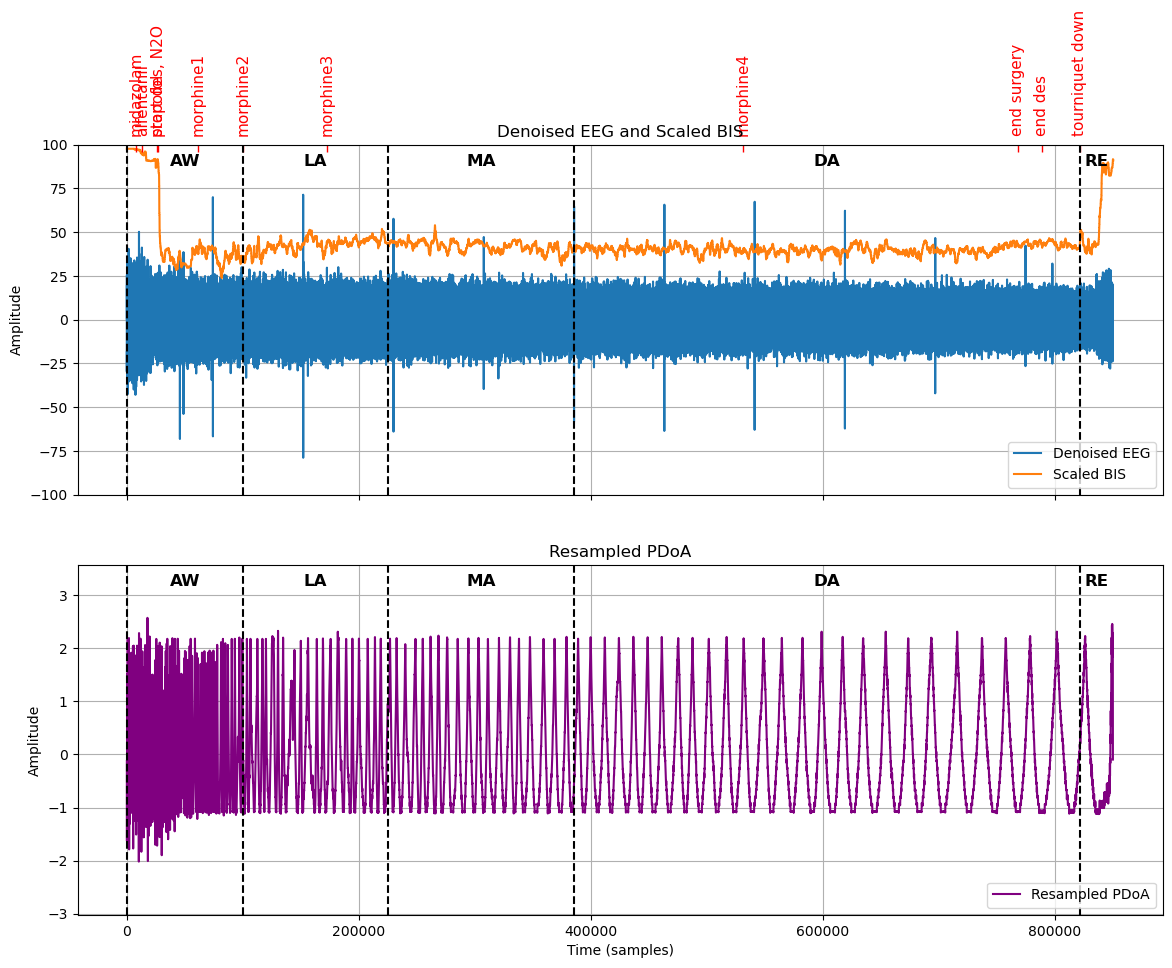

In [5]:
event_times = {
    "midazolam": "17:43:00",
    "alfentanil": "17:43:44",
    "propofol": "17:45:25",
    "start des, N2O": "17:45:30",
    "morphine1": "17:50:00",
    "morphine2": "17:55:00",
    "morphine3": "18:04:30",
    "morphine4": "18:51:10",
    "end surgery": "19:22:00",
    "end des": "19:24:40",
    "tourniquet down": "19:28:57"
}

time_seconds = {}
start_time = "17:42:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128
    
# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L05211742, label='Denoised EEG')
axs[0].plot(bis_L05211742, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L05211742, label='Resampled PDoA', color='purple')
axs[1].set_ylim(np.min(pdoa_L05211742) - 1, np.max(pdoa_L05211742) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L05211742_label = [
    (0, 99840, 'AW'),
    (99840, 225280, 'LA'),
    (225280, 385000, 'MA'),
    (385000, 821370, 'DA'),
    (821370, eeg_length, 'RE')
]

for start, end, label in L05211742_label:
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')

    
plt.show()

In [6]:
# Calculate entropy for each anesthesia state
for start, end, label in L05211742_label:
    state_eeg = eeg_L05211742['eeg'][start:end]
    entropy = shannon_entropy(state_eeg)
    print(f'{label} Entropy: {entropy}')

AW Entropy: 1.4126695589616491
LA Entropy: 1.2341940976505374
MA Entropy: 1.3961682011080472
DA Entropy: 1.2306534780427627
RE Entropy: 2.343355338311918


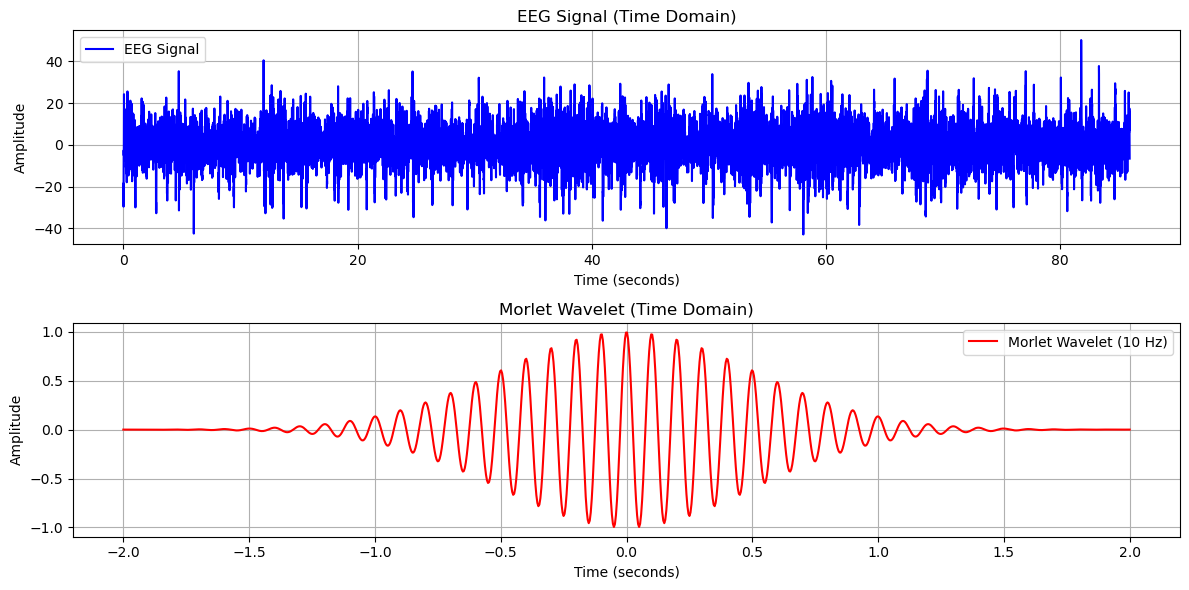

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Create a Morlet wavelet (time-domain wavelet) for visualization
def morlet_wavelet(t, f=10.0, sigma=0.2):
    """ Morlet wavelet function (time-domain wavelet) """
    return np.exp(-0.5 * (t / sigma) ** 2) * np.cos(2 * np.pi * f * t)

# Generate a Morlet wavelet with central frequency 10 Hz
t = np.linspace(-2, 2, 1000)  # Time axis
wavelet = morlet_wavelet(t, f=10, sigma=0.5)

# Select a segment of EEG for demonstration
eeg_signal = eeg_L05211742['eeg'][0:11000].values  # A small segment of EEG data

# Plot the EEG segment and the wavelet in the time domain
plt.figure(figsize=(12, 6))

# Plot EEG signal
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(eeg_signal)) / 128, eeg_signal, label='EEG Signal', color='blue')
plt.title('EEG Signal (Time Domain)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

# Plot the wavelet in the time domain
plt.subplot(2, 1, 2)
plt.plot(t, wavelet, label='Morlet Wavelet (10 Hz)', color='red')
plt.title('Morlet Wavelet (Time Domain)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


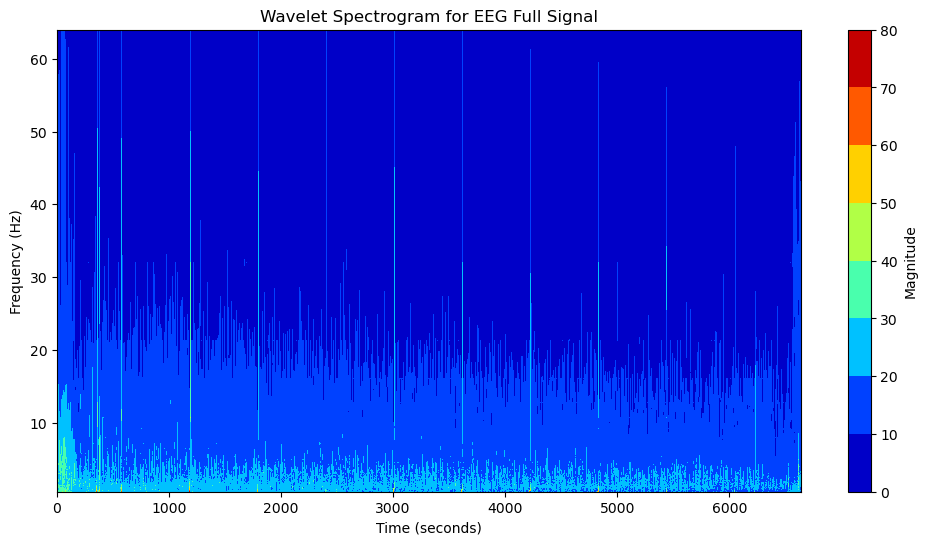

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

def plot_wavelet_spectrogram(signal, scales, wavelet='cmor', sampling_rate=128, label=None):
    # Perform Continuous Wavelet Transform (CWT)
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet, sampling_period=1/sampling_rate)
    
    # Plot the wavelet spectrogram (contour plot)
    plt.figure(figsize=(12, 6))
    plt.contourf(np.arange(len(signal)) / sampling_rate, frequencies, np.abs(coefficients), cmap='jet')
    plt.colorbar(label='Magnitude')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (seconds)')
    plt.title(f'Wavelet Spectrogram for {label}')
    plt.show()

# Define the range of scales (1 to 128 as an example)
scales = np.arange(1, 128)

# Plot the wavelet spectrogram for the entire EEG signal
plot_wavelet_spectrogram(eeg_L05211742['eeg'].values, scales, wavelet='cmor', label='EEG Full Signal')


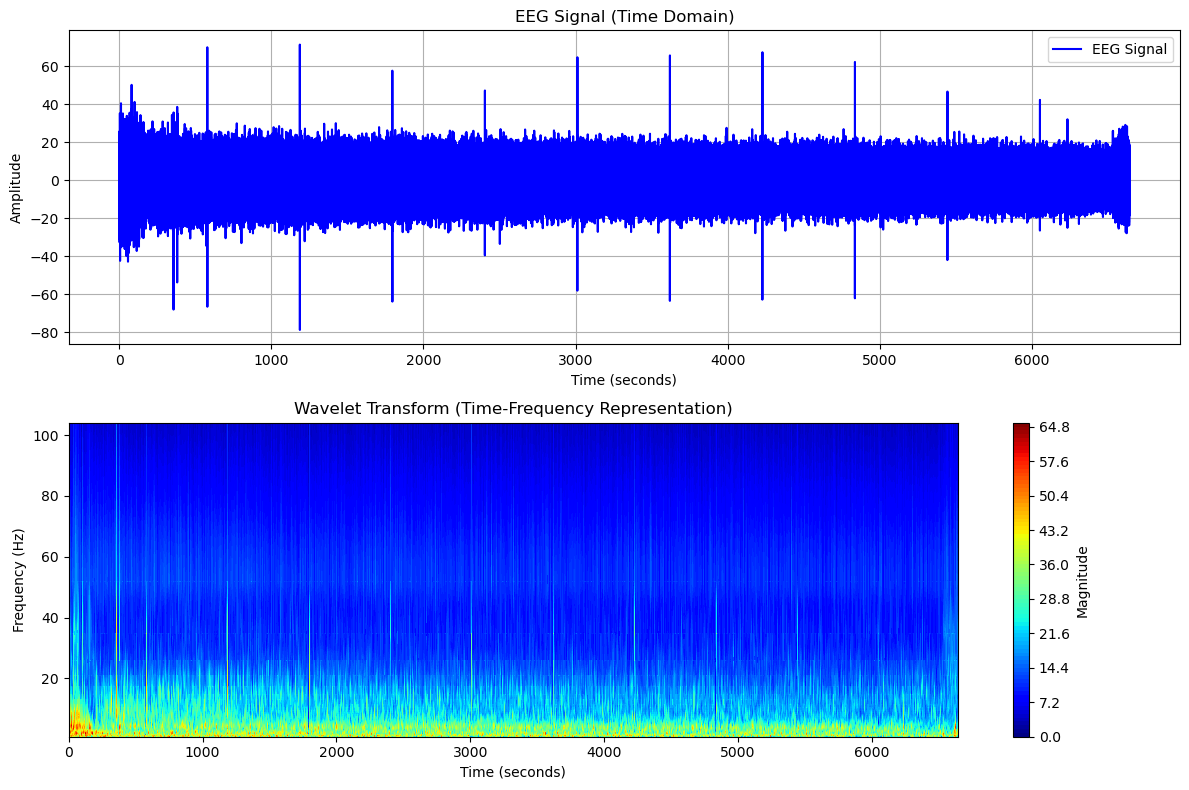

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Assuming the EEG data is already loaded, and it contains the entire data
eeg_signal = eeg_L05211742['eeg'].values  # Use the entire EEG signal
sampling_rate = 128  # Assuming the EEG signal is sampled at 128 Hz

# Compute the Continuous Wavelet Transform (CWT) for the whole EEG data
scales = np.arange(1, 128)  # You can adjust the scales depending on the frequency range you're interested in
coefficients, frequencies = pywt.cwt(eeg_signal, scales, 'morl', sampling_period=1/sampling_rate)

# Plot the EEG signal and its wavelet transform
plt.figure(figsize=(12, 8))

# Plot EEG signal (time domain)
plt.subplot(2, 1, 1)
time = np.arange(len(eeg_signal)) / sampling_rate
plt.plot(time, eeg_signal, label='EEG Signal', color='blue')
plt.title('EEG Signal (Time Domain)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

# Plot the wavelet coefficients (time-frequency representation)
plt.subplot(2, 1, 2)
plt.contourf(time, frequencies, np.abs(coefficients), cmap='jet', levels=100)
plt.title('Wavelet Transform (Time-Frequency Representation)')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Magnitude')

plt.tight_layout()
plt.show()


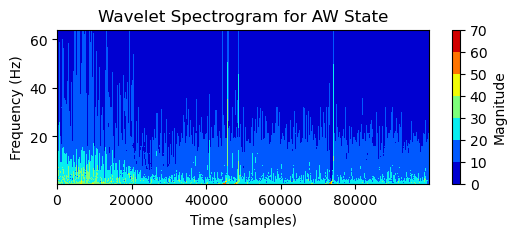

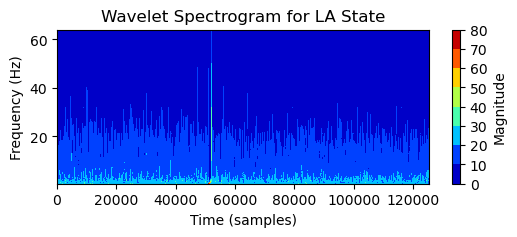

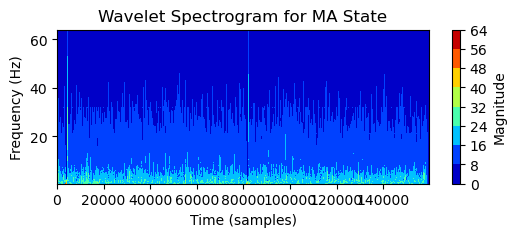

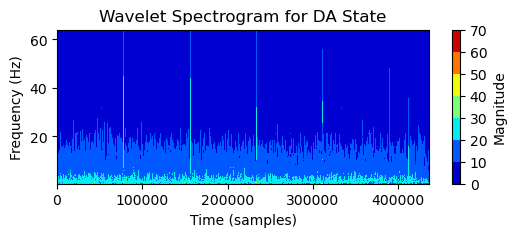

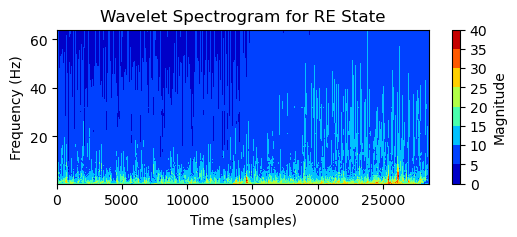

In [39]:
# Plot the wavelet spectrogram for each state
for start, end, label in L05211742_label:
    state_eeg = eeg_L05211742['eeg'][start:end].values
    plot_wavelet_spectrogram(state_eeg, scales, label=label)

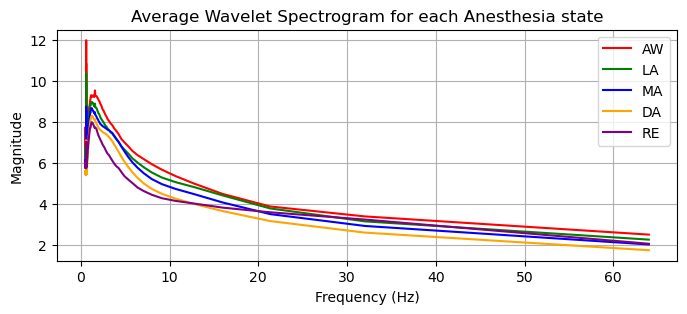

In [45]:
plt.figure(figsize=(8, 3))
colors = ['red', 'green', 'blue', 'orange', 'purple']

#Plot Average wavelet spectrogram for each state
for idx, (start, end, label) in enumerate(L05211742_label):
    state_eeg = eeg_L05211742['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    plt.plot(frequencies, avg_coefficients, color=colors[idx], label=label)

plt.title('Average Wavelet Spectrogram for each Anesthesia state')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [41]:
bis_time = np.linspace(0, len(eeg_L05211742), num=len(bis_L05211742), endpoint=False)
interp_func = interp1d(bis_time, bis_L05211742, kind='linear', fill_value='extrapolate')
bis_resampled = interp_func(np.arange(len(eeg_L05211742)))

average_bis = []

for start, end, label in L05211742_label:
    avg_bis = np.mean(bis_resampled[start:end])
    average_bis.append(avg_bis)
    print(f'{label} Average BIS: {avg_bis}')

AW Average BIS: 52.32988085919004
LA Average BIS: 42.7402206888134
MA Average BIS: 41.94058897901335
DA Average BIS: 40.28807140032588
RE Average BIS: 59.632597749458014


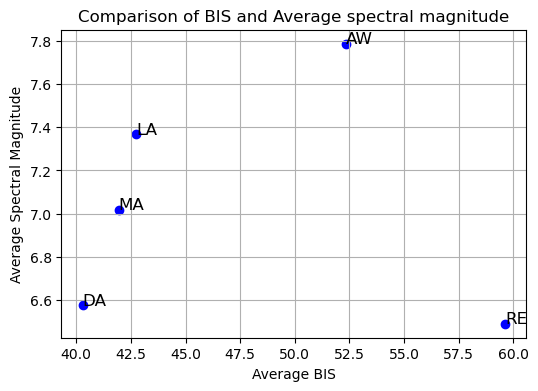

In [42]:
average_spectral_magnitude = []

for start, end, label in L05211742_label:
    state_eeg = eeg_L05211742['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    average_spectral_magnitude.append(np.mean(avg_coefficients))  # Averaging spectral magnitude over frequencies

# Plotting BIS vs Magnitude
plt.figure(figsize = (6, 4))
plt.scatter(average_bis, average_spectral_magnitude, color='blue')
for i, label in enumerate([state[2] for state in L05211742_label]):
    plt.text(average_bis[i], average_spectral_magnitude[i], label, fontsize=12)

plt.xlabel('Average BIS')
plt.ylabel('Average Spectral Magnitude')
plt.title('Comparison of BIS and Average spectral magnitude')
plt.grid(True)
plt.show()

In [8]:
eeg_segments = []
labels = []

for start, end, label in L05211742_label:
    eeg_segment = eeg_L05211742['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L05211742_eeg_label.csv', index=False)

In [97]:
# Extract BIS with label
L05211742_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L05211742_label:
    bis_values = bis_L05211742[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L05211742_bis_label = pd.concat([L05211742_bis_label, bis_segment_df], ignore_index=True)

L05211742_bis_label.to_csv('bis_label/L05211742_label.csv', index=False)

### L05200708

In [6]:
#EEG
L05200708 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L05200708.mat')

eeg_L05200708 = L05200708['xh']
eeg_L05200708 = pd.DataFrame(eeg_L05200708)
eeg_L05200708 = eeg_L05200708.stack().reset_index(drop=True).to_frame()
eeg_L05200708.columns = ['eeg']

#BIS
bis_L05200708 = np.repeat(bis['BIS_L05200708'].dropna().values, 128)

#PDOA
pdoa_L05200708 = pd.read_csv('pdoa/05200708.csv', header = None)
pdoa_L05200708.columns = ['X', 'pdoa']

eeg_length = len(eeg_L05200708)
pdoa_resampled = scipy.signal.resample(pdoa_L05200708['pdoa'], eeg_length)
pdoa_L05200708 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

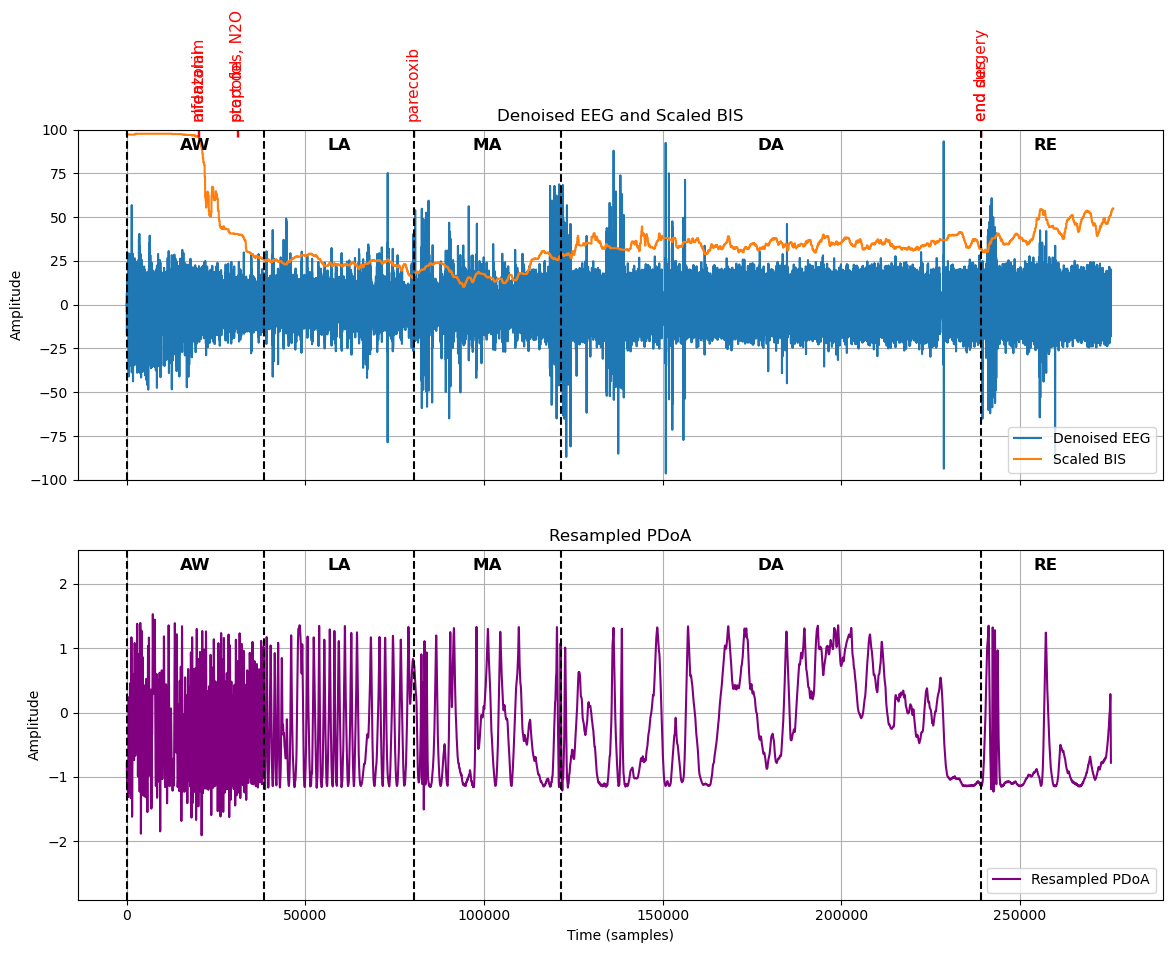

In [7]:
event_times = {
    "midazolam": "07:10:35",
    "alfentanil": "07:10:37",
    "propofol": "07:12:00",
    "start des, N2O": "07:12:02",
    "parecoxib": "07:18:27",
    "end des": "07:39:08",
    "end surgery": "07:39:08"
}

time_seconds = {}
start_time = "07:08:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L05200708, label='Denoised EEG')
axs[0].plot(bis_L05200708, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L05200708, label='Resampled PDoA', color='purple')
axs[1].set_ylim(min(pdoa_resampled) - 1, max(pdoa_resampled) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)
    
L05200708_label = [
    (0, 38400, 'AW'),
    (38400, 80256, 'LA'),
    (80256, 121600, 'MA'),
    (121600, 239104, 'DA'),
    (239104, eeg_length, 'RE')
]

for start, end, label in L05200708_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [34]:
# Calculate entropy for each anesthesia state
for start, end, label in L05200708_label:
    state_eeg = eeg_L05200708['eeg'][start:end]
    entropy = shannon_entropy(state_eeg)
    print(f'{label} Entropy: {entropy}')

AW Entropy: 1.643076377783415
LA Entropy: 1.1400544048032337
MA Entropy: 1.3475930081377203
DA Entropy: 1.1072650846562526
RE Entropy: 1.3714092850290411


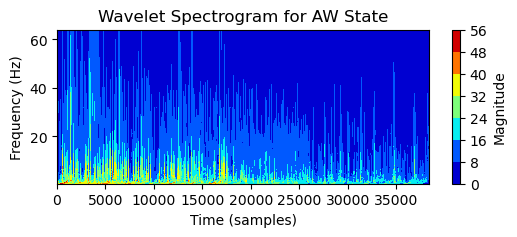

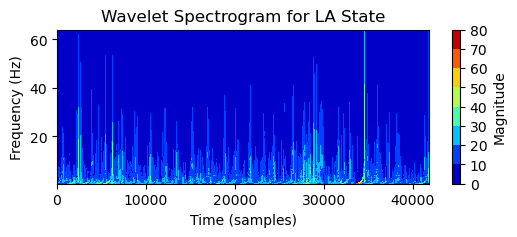

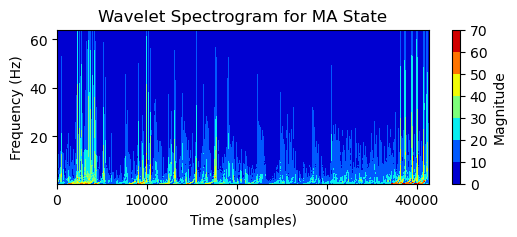

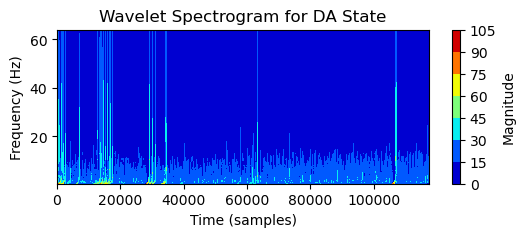

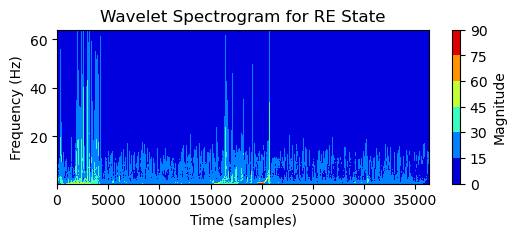

In [43]:
# Plot the wavelet spectrogram for each state
for start, end, label in L05200708_label:
    state_eeg = eeg_L05200708['eeg'][start:end].values
    plot_wavelet_spectrogram(state_eeg, scales, label=label)

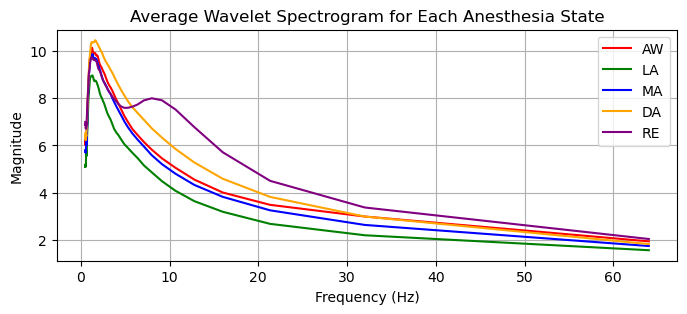

In [21]:
plt.figure(figsize=(8, 3))
colors = ['red', 'green', 'blue', 'orange', 'purple']

#Plot Average wavelet spectrogram for each state
for idx, (start, end, label) in enumerate(L05200708_label):
    state_eeg = eeg_L05200708['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    plt.plot(frequencies, avg_coefficients, color=colors[idx], label=label)

plt.title('Average Wavelet Spectrogram for each Anesthesia state')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

x axis (Frequency in Hz): This axis represents the frequency components of the EEG signal, ranging from very low frequencies up to 0.5 Hz. Frequencies beyond this range are not shown, as they likely have little energy or significance in the analysis of anesthesia states.

y-axis (Magnitude): The magnitude on this axis corresponds to the power or energy of the EEG signal at each frequency, as determined by the wavelet transform. Higher magnitudes indicate that the frequency component is more prominent or has more energy in the EEG signal.

Lower frequencies generally show higher magnitudes across all states. As frequency increases, the magnitude decreases for all states. The plot illustrates how the frequency content of the EEG signal changes with different levels of anesthesia. As the patient goes from being awake (AW) to deeper levels of anesthesia (LA, MA, DA), the energy at certain frequency bands decreases. This indicates that brain activity is slowing down and becoming more synchronized. The RE (Recovery) state shows some increase in low-frequency activity as the brain begins to return to a more active state, reflecting the process of emerging from anesthesia.

In [24]:
bis_time = np.linspace(0, len(eeg_L05200708), num=len(bis_L05200708), endpoint=False)
interp_func = interp1d(bis_time, bis_L05200708, kind='linear', fill_value='extrapolate')
bis_resampled = interp_func(np.arange(len(eeg_L05200708)))

average_bis = []

for start, end, label in L05200708_label:
    avg_bis = np.mean(bis_resampled[start:end])
    average_bis.append(avg_bis)
    print(f'{label} Average BIS: {avg_bis}')

AW Average BIS: 72.80295731972632
LA Average BIS: 24.06662833403054
MA Average BIS: 19.632700962521945
DA Average BIS: 34.55663424733479
RE Average BIS: 42.942299787135944


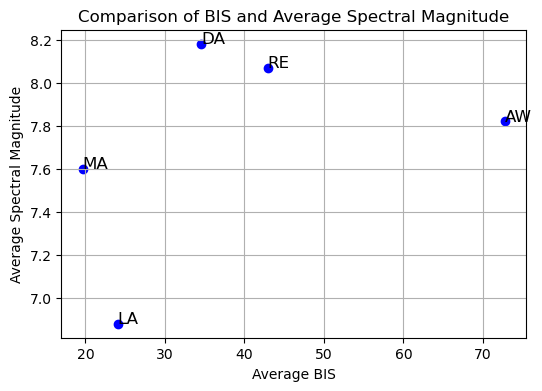

In [26]:
average_spectral_magnitude = []

for start, end, label in L05200708_label:
    state_eeg = eeg_L05200708['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    average_spectral_magnitude.append(np.mean(avg_coefficients))  # Averaging spectral magnitude over frequencies

# Plotting BIS vs Magnitude
plt.figure(figsize = (6, 4))
plt.scatter(average_bis, average_spectral_magnitude, color='blue')
for i, label in enumerate([state[2] for state in L05200708_label]):
    plt.text(average_bis[i], average_spectral_magnitude[i], label, fontsize=12)

plt.xlabel('Average BIS')
plt.ylabel('Average Spectral Magnitude')
plt.title('Comparison of BIS and Average spectral magnitude')
plt.grid(True)
plt.show()

The chart shows no correlation between BIS and the spectral magnitude of EEG, which could suggest limitations in the BIS index

In [22]:
# Extract EEG with label
eeg_segments = []
labels = []

for start, end, label in L05200708_label:
    eeg_segment = eeg_L05200708['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L05200708_eeg_label.csv', index=False)

In [98]:
# Extract BIS with label
L05200708_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L05200708_label:
    bis_values = bis_L05200708[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L05200708_bis_label = pd.concat([L05200708_bis_label, bis_segment_df], ignore_index=True)

L05200708_bis_label.to_csv('bis_label/L05200708_label.csv', index=False)

### L05250816

In [8]:
#EEG
L05250816 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L05250816.mat')

eeg_L05250816 = L05250816['xh']
eeg_L05250816 = pd.DataFrame(eeg_L05250816)
eeg_L05250816 = eeg_L05250816.stack().reset_index(drop = True).to_frame()
eeg_L05250816.columns = ['eeg']

#BIS
bis_L05250816 = np.repeat(bis['BIS_L05250816'].dropna().values, 128)

#PDOA
pdoa_L05250816 = pd.read_csv('pdoa/05250816.csv', header = None)
pdoa_L05250816.columns = ['X', 'pdoa']

eeg_length = len(eeg_L05250816)
pdoa_resampled = scipy.signal.resample(pdoa_L05250816['pdoa'], eeg_length)
pdoa_L05250816 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

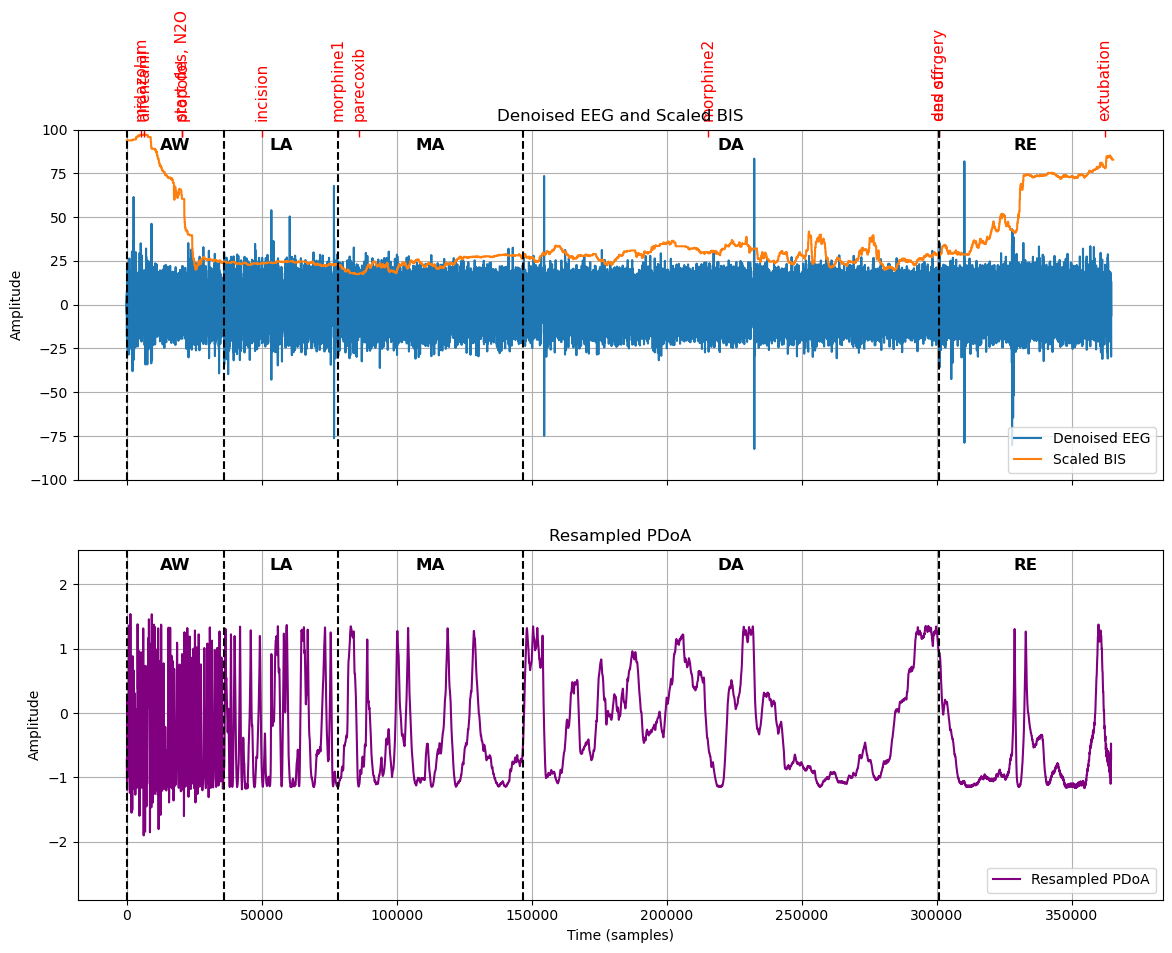

In [9]:
event_times = {
    "midazolam": "08:16:40",
    "alfentanil": "08:16:50",
    "propofol": "08:18:40",
    "start des, N2O": "08:18:40",
    "incision": "08:22:30",
    "morphine1": "08:26:11",
    "parecoxib": "08:27:13",
    "morphine2": "08:44:01",
    "des off": "08:55:11",
    "end surgery": "08:55:11",
    "extubation": "09:03:10"
}

time_seconds = {}
start_time = "08:16:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128
    
# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L05250816, label='Denoised EEG')
axs[0].plot(bis_L05250816, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L05250816, label='Resampled PDoA', color='purple')
axs[1].set_ylim(min(pdoa_resampled) - 1, max(pdoa_resampled) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L05250816_label = [
    (0, 35840, 'AW'),
    (35840, 78208, 'LA'),
    (78208, 146560, 'MA'),
    (146560, 300928, 'DA'),
    (300928, eeg_length, 'RE')
]

for start, end, label in L05250816_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [37]:
# Calculate entropy for each anesthesia state
for start, end, label in L05250816_label:
    state_eeg = eeg_L05250816['eeg'][start:end]
    entropy = shannon_entropy(state_eeg)
    print(f'{label} Entropy: {entropy}')

AW Entropy: 1.6164022341783497
LA Entropy: 1.1822398149886846
MA Entropy: 2.100985828199918
DA Entropy: 1.1378887053586513
RE Entropy: 1.2086768527312721


/Users/pdmnhtrang/anaconda3/lib/python3.11/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


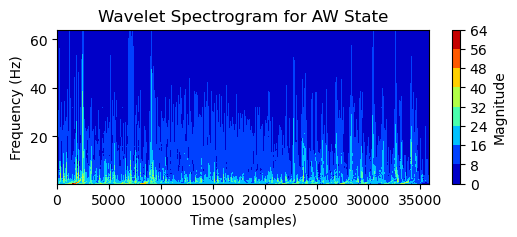

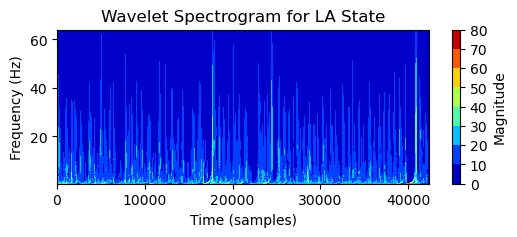

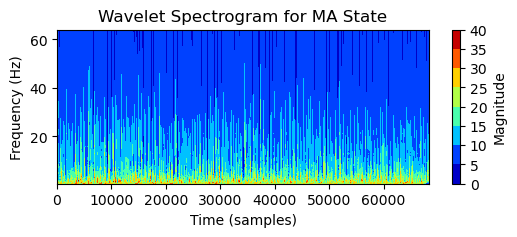

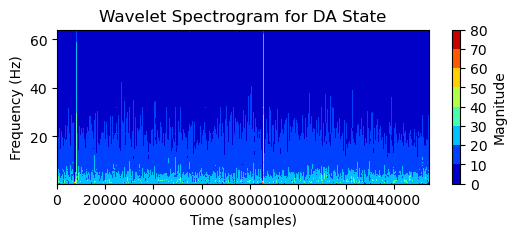

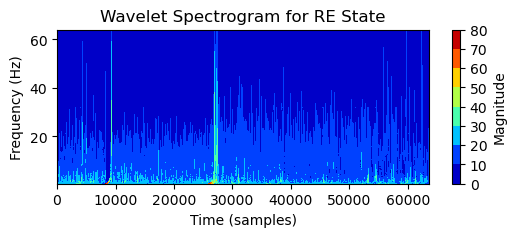

In [50]:
# Plot the wavelet spectrogram for each state
for start, end, label in L05250816_label:
    state_eeg = eeg_L05250816['eeg'][start:end].values
    plot_wavelet_spectrogram(state_eeg, scales, label=label)

/Users/pdmnhtrang/anaconda3/lib/python3.11/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


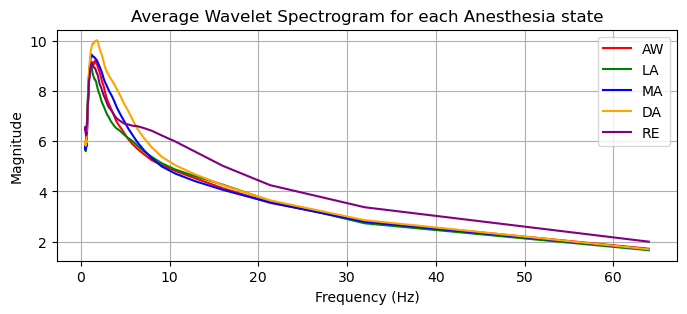

In [15]:
plt.figure(figsize=(8, 3))
colors = ['red', 'green', 'blue', 'orange', 'purple']

#Plot Average wavelet spectrogram for each state
for idx, (start, end, label) in enumerate(L05250816_label):
    state_eeg = eeg_L05250816['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    plt.plot(frequencies, avg_coefficients, color=colors[idx], label=label)

plt.title('Average Wavelet Spectrogram for each Anesthesia state')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [16]:
bis_time = np.linspace(0, len(eeg_L05250816), num=len(bis_L05250816), endpoint=False)
interp_func = interp1d(bis_time, bis_L05250816, kind='linear', fill_value='extrapolate')
bis_resampled = interp_func(np.arange(len(eeg_L05250816)))

average_bis = []

for start, end, label in L05250816_label:
    avg_bis = np.mean(bis_resampled[start:end])
    average_bis.append(avg_bis)
    print(f'{label} Average BIS: {avg_bis}')

AW Average BIS: 60.79757147753501
LA Average BIS: 23.789778922092314
MA Average BIS: 23.838192233001294
DA Average BIS: 28.888249148657273
RE Average BIS: 57.792423543824704


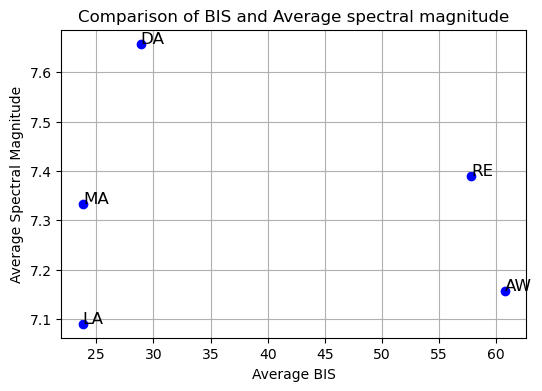

In [17]:
average_spectral_magnitude = []

for start, end, label in L05250816_label:
    state_eeg = eeg_L05250816['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    average_spectral_magnitude.append(np.mean(avg_coefficients))  

# Plotting BIS vs Magnitude
plt.figure(figsize = (6, 4))
plt.scatter(average_bis, average_spectral_magnitude, color = 'blue')
for i, label in enumerate([state[2] for state in L05250816_label]):
    plt.text(average_bis[i], average_spectral_magnitude[i], label, fontsize=12)

plt.xlabel('Average BIS')
plt.ylabel('Average Spectral Magnitude')
plt.title('Comparison of BIS and Average spectral magnitude')
plt.grid(True)
plt.show()

In [23]:
eeg_segments = []
labels = []

for start, end, label in L05250816_label:
    eeg_segment = eeg_L05250816['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L05250816_eeg_label.csv', index=False)

In [99]:
# Extract BIS with label
L05250816_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L05250816_label:
    bis_values = bis_L05250816[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L05250816_bis_label = pd.concat([L05250816_bis_label, bis_segment_df], ignore_index=True)

L05250816_bis_label.to_csv('bis_label/L05250816_label.csv', index=False)

### L05250921

In [10]:
#EEG
L05250921 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L05250921.mat')

eeg_L05250921 = L05250921['xh']
eeg_L05250921 = pd.DataFrame(eeg_L05250921)
eeg_L05250921 = eeg_L05250921.stack().reset_index(drop = True).to_frame()
eeg_L05250921.columns = ['eeg']

#BIS
bis_L05250921 = np.repeat(bis['BIS L05250921'].dropna().values, 128)
 
#PDOA
pdoa_L05250921 = pd.read_csv('pdoa/05250921.csv', header = None)
pdoa_L05250921.columns = ['X', 'pdoa']

eeg_length = len(eeg_L05250921)
pdoa_resampled = scipy.signal.resample(pdoa_L05250921['pdoa'], eeg_length)
pdoa_L05250921 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

In [11]:
#Normalise
pdoa_L05250921['pdoa'] = (pdoa_L05250921['pdoa'] - pdoa_L05250921['pdoa'].mean()) / pdoa_L05250921['pdoa'].std()

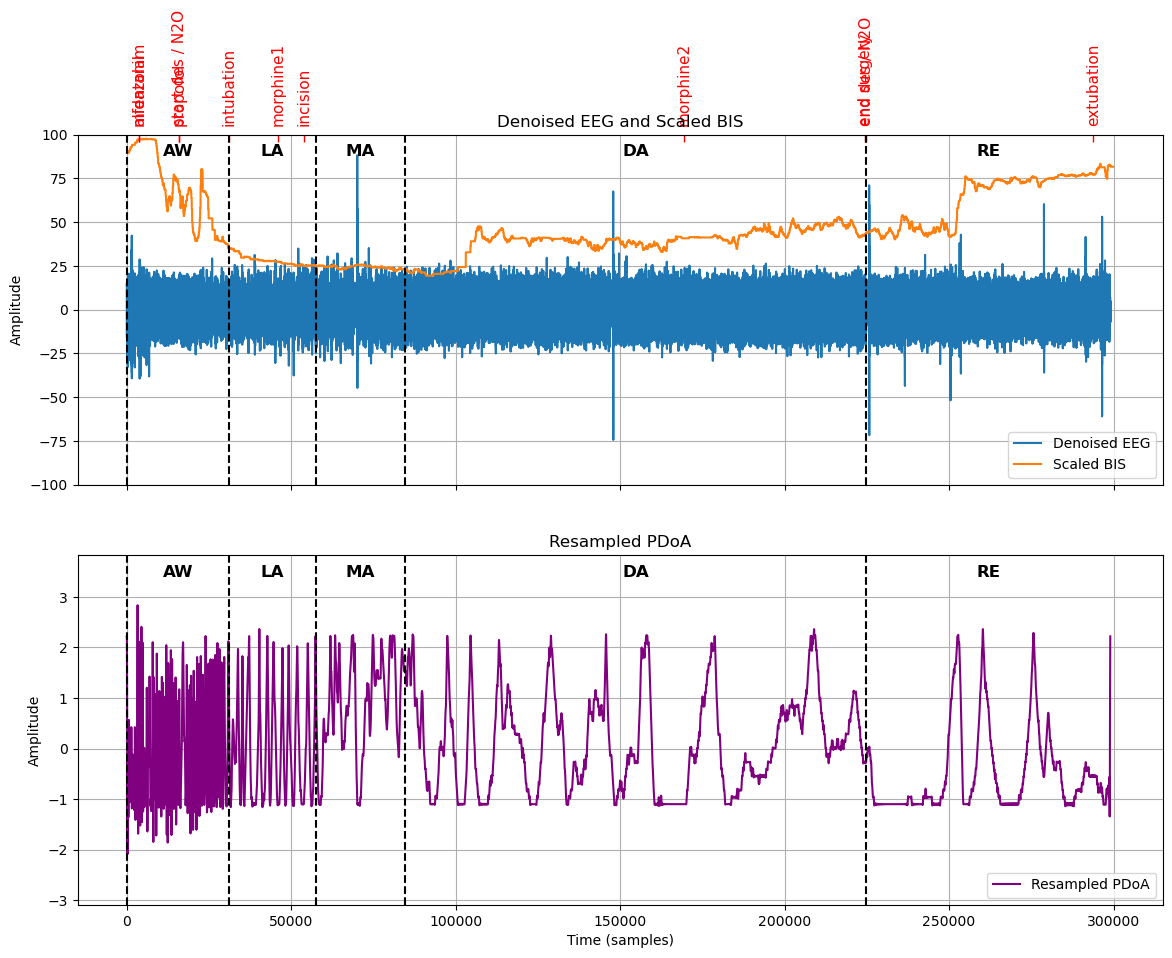

In [12]:
event_times = {
    "midazolam": "09:21:30",
    "alfentanil": "09:21:30",
    "propofol": "09:23:05",
    "start des / N2O": "09:23:05",
    "intubation": "09:25:03",
    "morphine1": "09:26:59",
    "incision": "09:28:00",
    "morphine2": "09:43:03",
    "end surgery": "09:50:14",
    "end des / N2O": "09:50:16",
    "extubation": "09:59:16"
}

time_seconds = {}
start_time = "09:21:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L05250921, label='Denoised EEG')
axs[0].plot(bis_L05250921, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L05250921, label='Resampled PDoA', color='purple')
axs[1].set_ylim(np.min(pdoa_L05250921) - 1, np.max(pdoa_L05250921) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L05250921_label = [
    (0, 31104, 'AW'),
    (31104, 57600, 'LA'),
    (57600, 84480, 'MA'),
    (84480, 224768, 'DA'),
    (224768, eeg_length, 'RE')
]

for start, end, label in L05250921_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [41]:
# Calculate entropy for each anesthesia state
for start, end, label in L05250921_label:
    state_eeg = eeg_L05200708['eeg'][start:end]
    entropy = shannon_entropy(state_eeg)
    print(f'{label} Entropy: {entropy}')

AW Entropy: 1.7056064318482047
LA Entropy: 1.591500192920077
MA Entropy: 1.193485597062823
DA Entropy: 1.0984812559841641
RE Entropy: 1.1693529621861287


/Users/pdmnhtrang/anaconda3/lib/python3.11/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


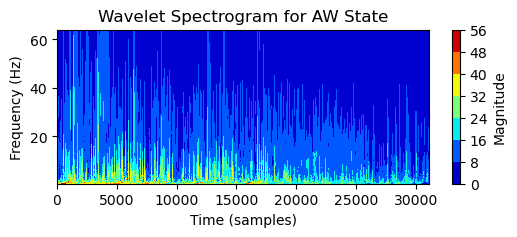

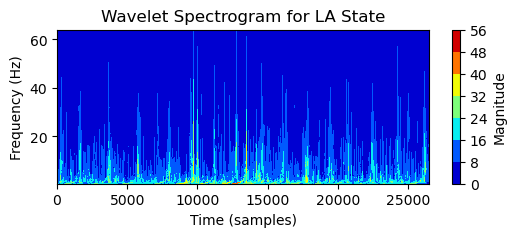

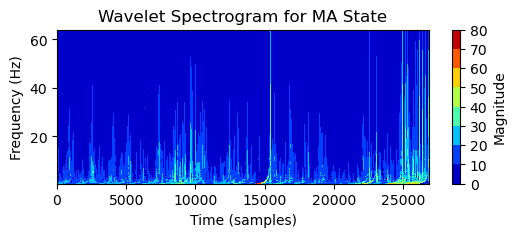

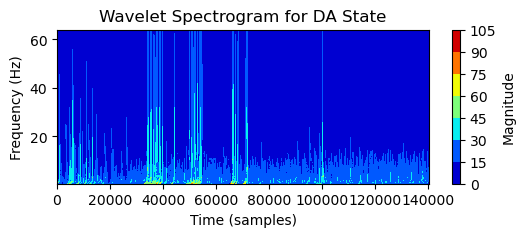

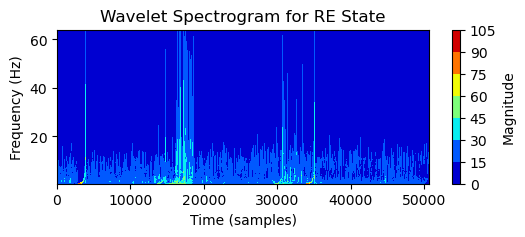

In [59]:
# Plot the wavelet spectrogram for each state
for start, end, label in L05250921_label:
    state_eeg = eeg_L05200708['eeg'][start:end].values
    plot_wavelet_spectrogram(state_eeg, scales, label=label)

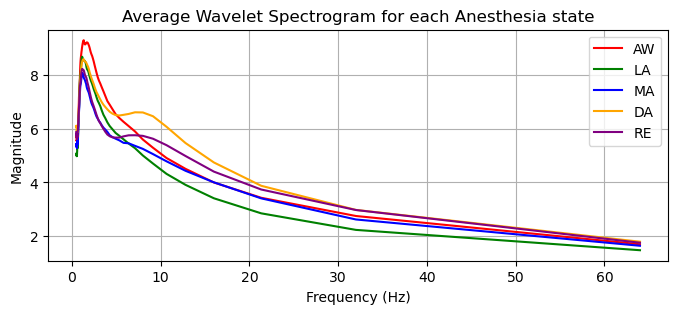

In [60]:
plt.figure(figsize=(8, 3))
colors = ['red', 'green', 'blue', 'orange', 'purple']

#Plot Average wavelet spectrogram for each state
for idx, (start, end, label) in enumerate(L05250921_label):
    state_eeg = eeg_L05250921['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    plt.plot(frequencies, avg_coefficients, color=colors[idx], label=label)

plt.title('Average Wavelet Spectrogram for each Anesthesia state')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [42]:
bis_time = np.linspace(0, len(eeg_L05250921), num=len(bis_L05250921), endpoint=False)
interp_func = interp1d(bis_time, bis_L05250921, kind='linear', fill_value='extrapolate')
bis_resampled = interp_func(np.arange(len(eeg_L05250921)))

average_bis = []

for start, end, label in L05250921_label:
    avg_bis = np.mean(bis_resampled[start:end])
    average_bis.append(avg_bis)
    print(f'{label} Average BIS: {avg_bis}')

AW Average BIS: 69.02404707392039
LA Average BIS: 28.035143726285025
MA Average BIS: 24.32699558122952
DA Average BIS: 39.070820436938185
RE Average BIS: 64.05109416684373


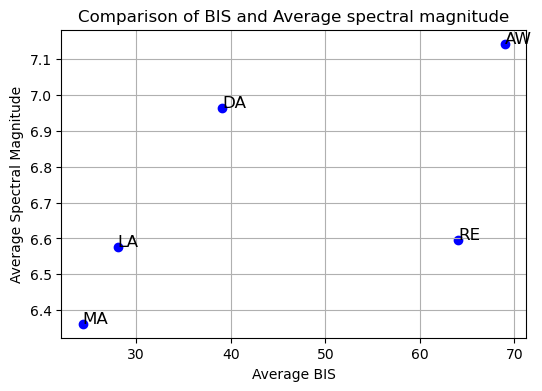

In [62]:
average_spectral_magnitude = []

for start, end, label in L05250921_label:
    state_eeg = eeg_L05250921['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    average_spectral_magnitude.append(np.mean(avg_coefficients))  # Averaging spectral magnitude over frequencies

# Plotting BIS vs Magnitude
plt.figure(figsize = (6, 4))
plt.scatter(average_bis, average_spectral_magnitude, color='blue')
for i, label in enumerate([state[2] for state in L05200708_label]):
    plt.text(average_bis[i], average_spectral_magnitude[i], label, fontsize=12)

plt.xlabel('Average BIS')
plt.ylabel('Average Spectral Magnitude')
plt.title('Comparison of BIS and Average spectral magnitude')
plt.grid(True)
plt.show()

In [24]:
eeg_segments = []
labels = []

for start, end, label in L05250921_label:
    eeg_segment = eeg_L05250921['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L05250921_eeg_label.csv', index=False)

In [100]:
# Extract BIS with label
L05250921_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L05250921_label:
    bis_values = bis_L05250921[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L05250921_bis_label = pd.concat([L05250921_bis_label, bis_segment_df], ignore_index=True)

L05250921_bis_label.to_csv('bis_label/L05250921_label.csv', index=False)

### L05271431

In [13]:
#EEG
L05271431 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L05271431.mat')

eeg_L05271431 = L05271431['xh']
eeg_L05271431 = pd.DataFrame(eeg_L05271431)
eeg_L05271431 = eeg_L05271431.stack().reset_index(drop = True).to_frame()
eeg_L05271431.columns = ['eeg']

#BIS
bis_L05271431 = np.repeat(bis['BIS_L05271431'].dropna().values, 128)

#PDOA
pdoa_L05271431 = pd.read_csv('pdoa/05271431.csv', header = None)
pdoa_L05271431.columns = ['X', 'pdoa']

eeg_length = len(eeg_L05271431)
pdoa_resampled = scipy.signal.resample(pdoa_L05271431['pdoa'], eeg_length)
pdoa_L05271431 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

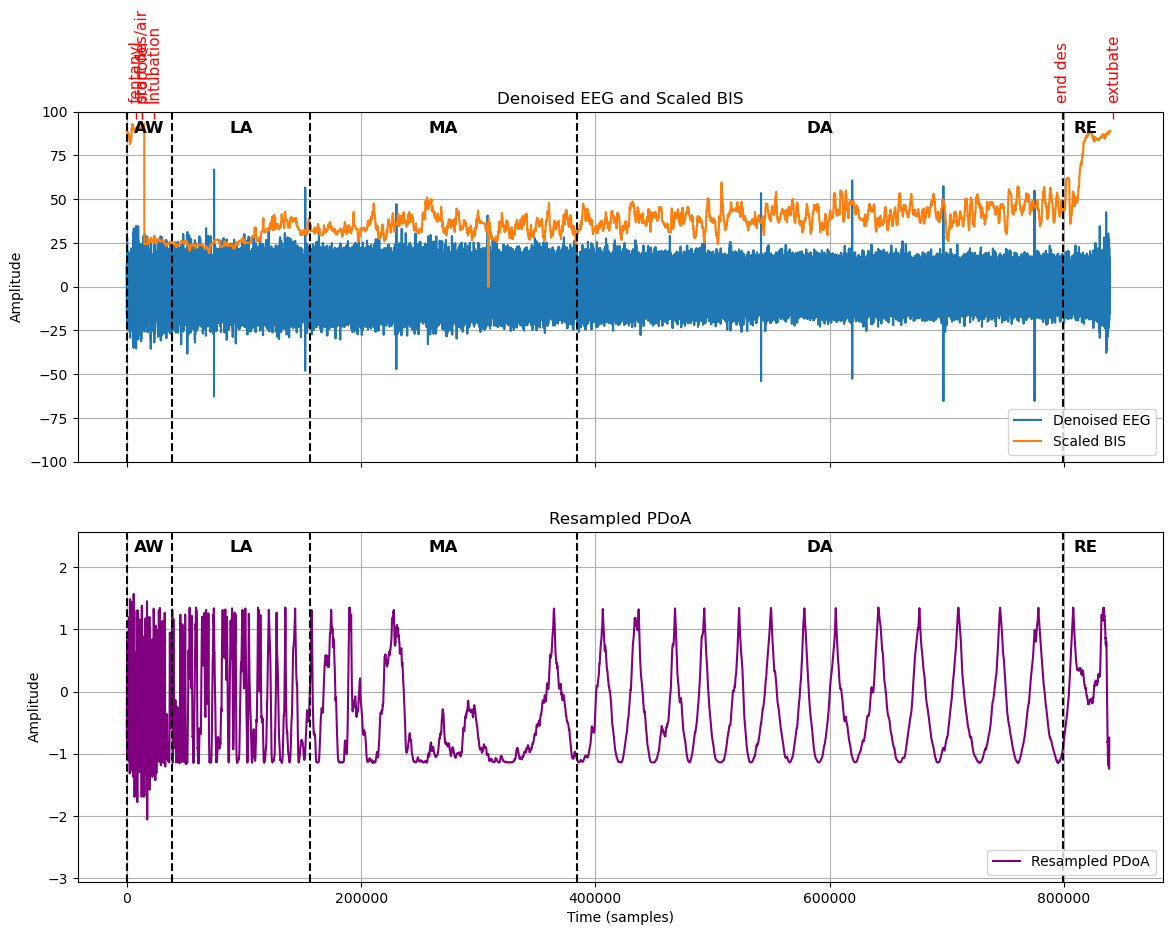

In [14]:
event_times = {
    "fentanyl": "14:32:03",
    "propofol": "14:32:42",
    "start des/air": "14:32:44",
    "intubation": "14:34:00",
    "end des": "16:15:00",
    "extubate": "16:20:38"
}

time_seconds = {}
start_time = "14:31:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L05271431, label='Denoised EEG')
axs[0].plot(bis_L05271431, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L05271431, label='Resampled PDoA', color='purple')
axs[1].set_ylim(min(pdoa_resampled) - 1, max(pdoa_resampled) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L05271431_label = [
    (0, 38400, 'AW'),
    (38400, 156160, 'LA'),
    (156160, 384000, 'MA'),
    (384000, 798720, 'DA'),
    (798720, eeg_length, 'RE')
]

for start, end, label in L05271431_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [45]:
# Calculate entropy for each anesthesia state
for start, end, label in L05271431_label:
    state_eeg = eeg_L05271431['eeg'][start:end]
    entropy = shannon_entropy(state_eeg)
    print(f'{label} Entropy: {entropy}')

AW Entropy: 2.0318600358474765
LA Entropy: 1.341628838513686
MA Entropy: 1.7171279643266766
DA Entropy: 1.2322206170764645
RE Entropy: 1.8156754132527761


/Users/pdmnhtrang/anaconda3/lib/python3.11/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


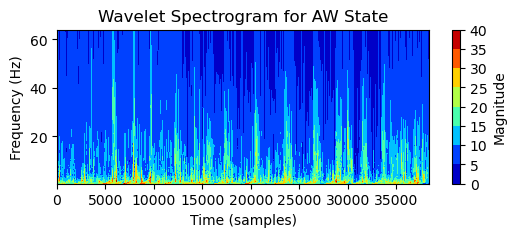

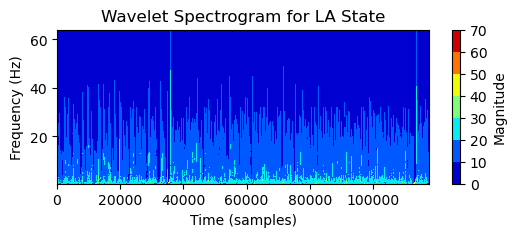

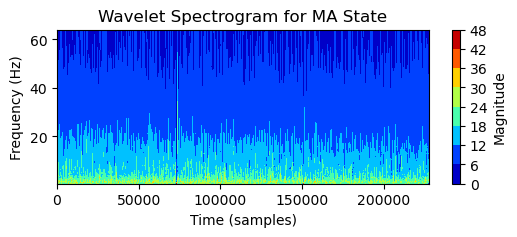

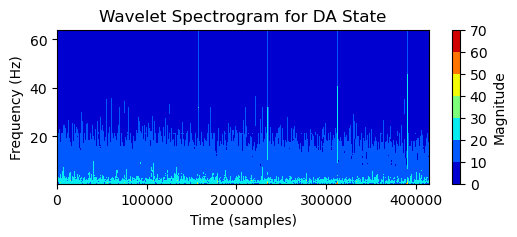

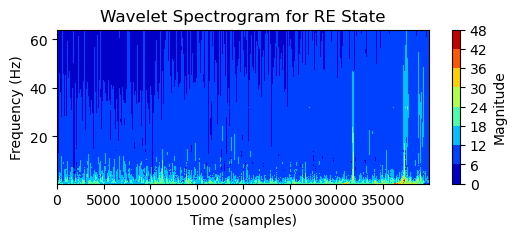

In [66]:
# Plot the wavelet spectrogram for each state
for start, end, label in L05271431_label:
    state_eeg = eeg_L05271431['eeg'][start:end].values
    plot_wavelet_spectrogram(state_eeg, scales, label=label)

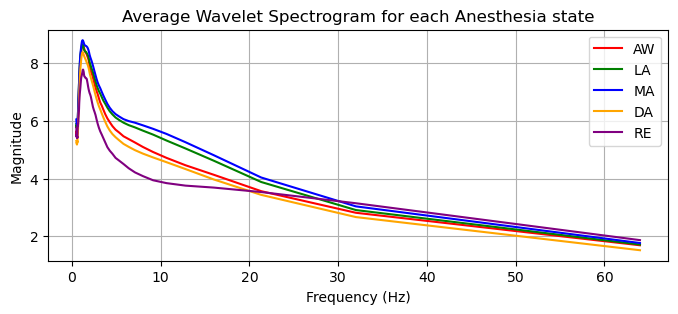

In [67]:
plt.figure(figsize=(8, 3))
colors = ['red', 'green', 'blue', 'orange', 'purple']

#Plot Average wavelet spectrogram for each state
for idx, (start, end, label) in enumerate(L05271431_label):
    state_eeg = eeg_L05271431['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    plt.plot(frequencies, avg_coefficients, color=colors[idx], label=label)

plt.title('Average Wavelet Spectrogram for each Anesthesia state')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [68]:
bis_time = np.linspace(0, len(eeg_L05271431), num=len(bis_L05271431), endpoint=False)
interp_func = interp1d(bis_time, bis_L05271431, kind='linear', fill_value='extrapolate')
bis_resampled = interp_func(np.arange(len(eeg_L05271431)))

average_bis = []

for start, end, label in L05271431_label:
    avg_bis = np.mean(bis_resampled[start:end])
    average_bis.append(avg_bis)
    print(f'{label} Average BIS: {avg_bis}')

AW Average BIS: 50.28133567785808
LA Average BIS: 28.34215044129784
MA Average BIS: 34.61619667695601
DA Average BIS: 41.030337584618955
RE Average BIS: 72.67832093808575


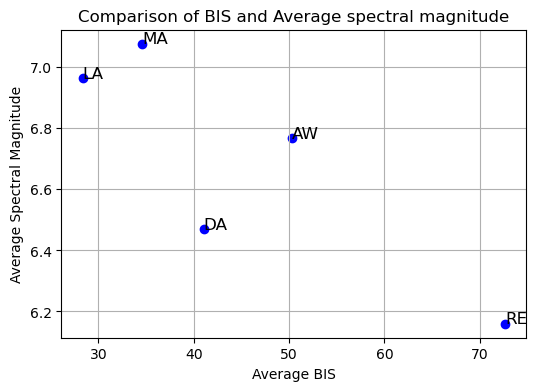

In [69]:
average_spectral_magnitude = []

for start, end, label in L05271431_label:
    state_eeg = eeg_L05271431['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    average_spectral_magnitude.append(np.mean(avg_coefficients))  # Averaging spectral magnitude over frequencies

# Plotting BIS vs Magnitude
plt.figure(figsize = (6, 4))
plt.scatter(average_bis, average_spectral_magnitude, color='blue')
for i, label in enumerate([state[2] for state in L05271431_label]):
    plt.text(average_bis[i], average_spectral_magnitude[i], label, fontsize=12)

plt.xlabel('Average BIS')
plt.ylabel('Average Spectral Magnitude')
plt.title('Comparison of BIS and Average spectral magnitude')
plt.grid(True)
plt.show()

In [27]:
eeg_segments = []
labels = []

for start, end, label in L05271431_label:
    eeg_segment = eeg_L05271431['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L05271431_eeg_label.csv', index=False)

In [101]:
# Extract BIS with label
L05271431_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L05271431_label:
    bis_values = bis_L05271431[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L05271431_bis_label = pd.concat([L05271431_bis_label, bis_segment_df], ignore_index=True)

L05271431_bis_label.to_csv('bis_label/L05271431_label.csv', index=False)

### L05281010

In [15]:
#EEG
L05281010 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L05281010.mat')

eeg_L05281010 = L05281010['xh']
eeg_L05281010 = pd.DataFrame(eeg_L05281010)
eeg_L05281010 = eeg_L05281010.stack().reset_index(drop = True).to_frame()
eeg_L05281010.columns = ['eeg']

#BIS
bis_L05281010 = np.repeat(bis['BIS_05281010'].dropna().values, 128)

#PDOA
pdoa_L05281010 = pd.read_csv('pdoa/05281010.csv', header = None)
pdoa_L05281010.columns = ['X', 'pdoa']

eeg_length = len(eeg_L05281010)
pdoa_resampled = scipy.signal.resample(pdoa_L05281010['pdoa'], eeg_length)
pdoa_L05281010 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

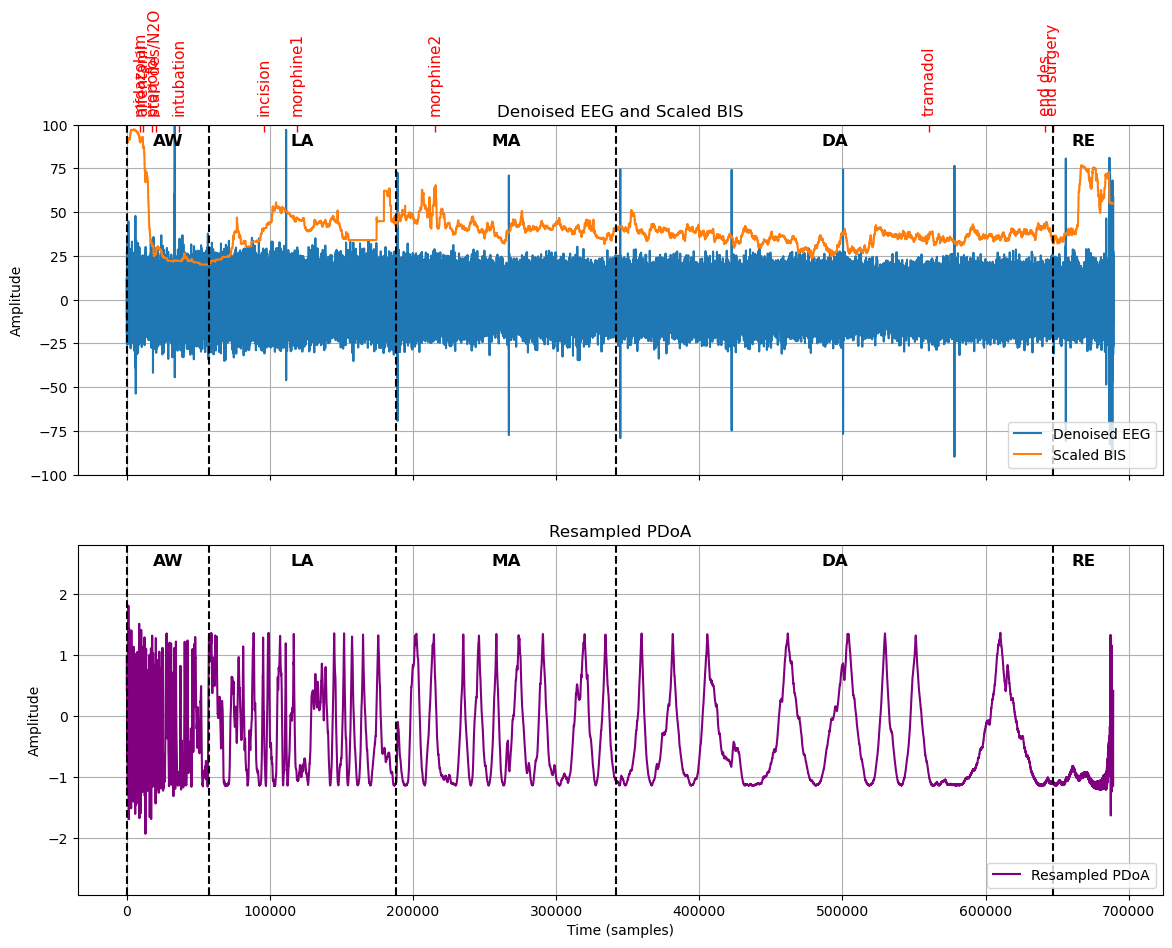

In [16]:
event_times = {
    "midazolam": "10:11:12",
    "alfentanil": "10:11:26",
    "propofol": "10:12:20",
    "start des/N2O": "10:12:38",
    "intubation": "10:14:45",
    "incision": "10:22:28",
    "morphine1": "10:25:30",
    "morphine2": "10:38:02",
    "tramadol": "11:23:00",
    "end des": "11:33:33",
    "end surgery": "11:34:15"
}

time_seconds = {}
start_time = "10:10:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L05281010, label='Denoised EEG')
axs[0].plot(bis_L05281010, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L05281010, label='Resampled PDoA', color='purple')
axs[1].set_ylim(min(pdoa_resampled) - 1, max(pdoa_resampled) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L05281010_label = [
    (0, 57600, 'AW'),
    (57600, 188160, 'LA'),
    (188160, 341760, 'MA'),
    (341760, 647040, 'DA'),
    (647040, eeg_length, 'RE')
]

for start, end, label in L05281010_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [48]:
# Calculate entropy for each anesthesia state
for start, end, label in L05281010_label:
    state_eeg = eeg_L05281010['eeg'][start:end]
    entropy = shannon_entropy(state_eeg)
    print(f'{label} Entropy: {entropy}')

AW Entropy: 1.2085095440894487
LA Entropy: 1.4033439599285191
MA Entropy: 1.2599649422096122
DA Entropy: 1.080794315184435
RE Entropy: 1.2190170149135056


/Users/pdmnhtrang/anaconda3/lib/python3.11/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


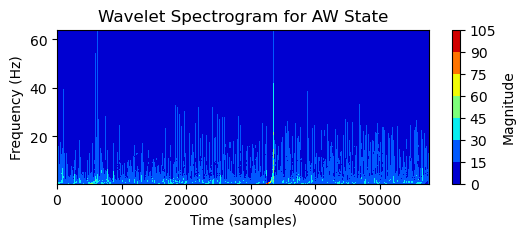

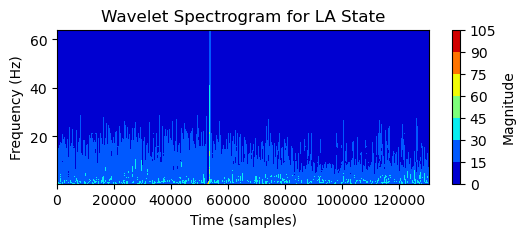

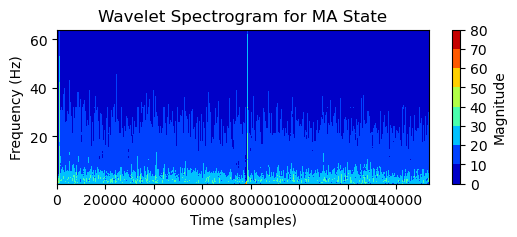

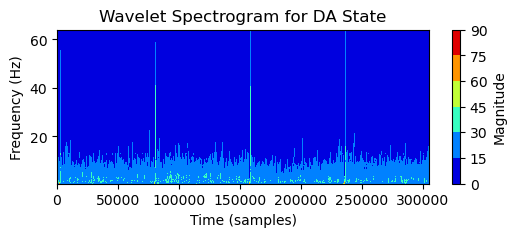

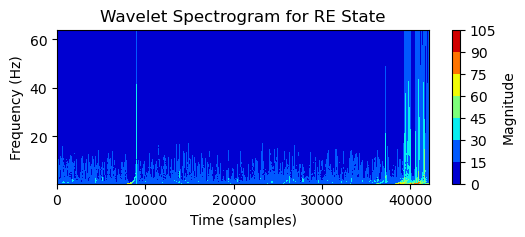

In [156]:
# Plot the wavelet spectrogram for each state
for start, end, label in L05281010_label:
    state_eeg = eeg_L05281010['eeg'][start:end].values
    plot_wavelet_spectrogram(state_eeg, scales, label=label)

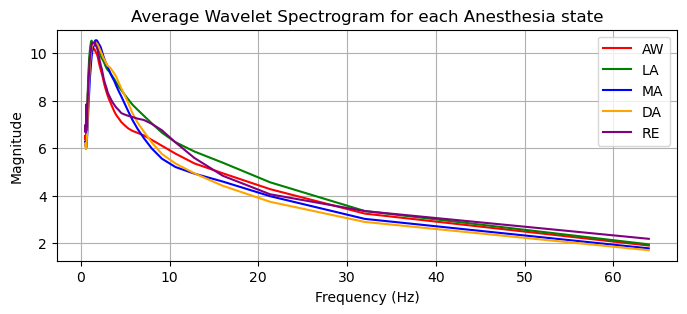

In [157]:
plt.figure(figsize=(8, 3))
colors = ['red', 'green', 'blue', 'orange', 'purple']

#Plot Average wavelet spectrogram for each state
for idx, (start, end, label) in enumerate(L05281010_label):
    state_eeg = eeg_L05281010['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    plt.plot(frequencies, avg_coefficients, color=colors[idx], label=label)

plt.title('Average Wavelet Spectrogram for each Anesthesia state')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [158]:
bis_time = np.linspace(0, len(eeg_L05281010), num=len(bis_L05281010), endpoint=False)
interp_func = interp1d(bis_time, bis_L05281010, kind='linear', fill_value='extrapolate')
bis_resampled = interp_func(np.arange(len(eeg_L05281010)))

average_bis = []

for start, end, label in L05281010_label:
    avg_bis = np.mean(bis_resampled[start:end])
    average_bis.append(avg_bis)
    print(f'{label} Average BIS: {avg_bis}')

AW Average BIS: 41.119747713868826
LA Average BIS: 39.48913365416106
MA Average BIS: 42.222826182764564
DA Average BIS: 35.85524704485099
RE Average BIS: 54.23391029365883


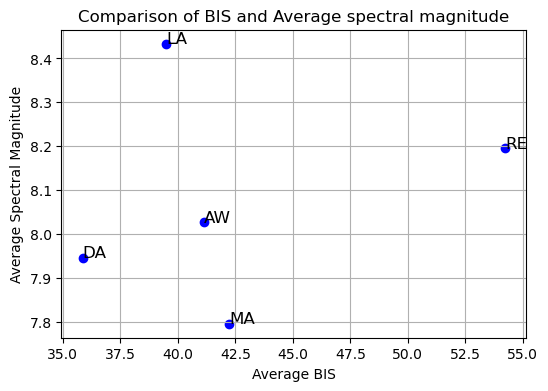

In [159]:
average_spectral_magnitude = []

for start, end, label in L05281010_label:
    state_eeg = eeg_L05281010['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    average_spectral_magnitude.append(np.mean(avg_coefficients))  # Averaging spectral magnitude over frequencies

# Plotting BIS vs Magnitude
plt.figure(figsize = (6, 4))
plt.scatter(average_bis, average_spectral_magnitude, color='blue')
for i, label in enumerate([state[2] for state in L05281010_label]):
    plt.text(average_bis[i], average_spectral_magnitude[i], label, fontsize=12)

plt.xlabel('Average BIS')
plt.ylabel('Average Spectral Magnitude')
plt.title('Comparison of BIS and Average spectral magnitude')
plt.grid(True)
plt.show()

In [30]:
eeg_segments = []
labels = []

for start, end, label in L05281010_label:
    eeg_segment = eeg_L05281010['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L05281010_eeg_label.csv', index=False)

In [102]:
# Extract BIS with label
L05281010_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L05281010_label:
    bis_values = bis_L05281010[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L05281010_bis_label = pd.concat([L05281010_bis_label, bis_segment_df], ignore_index=True)

L05281010_bis_label.to_csv('bis_label/L05281010_label.csv', index=False)

### L06101015

In [17]:
#EEG
L06101015 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L06101015.mat')

eeg_L06101015 = L06101015['xh']
eeg_L06101015 = pd.DataFrame(eeg_L06101015)
eeg_L06101015 = eeg_L06101015.stack().reset_index(drop = True).to_frame()
eeg_L06101015.columns = ['eeg']

#BIS
bis_L06101015 = np.repeat(bis['BIS_L06101015'].dropna().values, 128)

#PDOA
pdoa_L06101015 = pd.read_csv('pdoa/06101015.csv', header = None)
pdoa_L06101015.columns = ['X', 'pdoa']

eeg_length = len(eeg_L06101015)
pdoa_resampled = scipy.signal.resample(pdoa_L06101015['pdoa'], eeg_length)
pdoa_L06101015 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

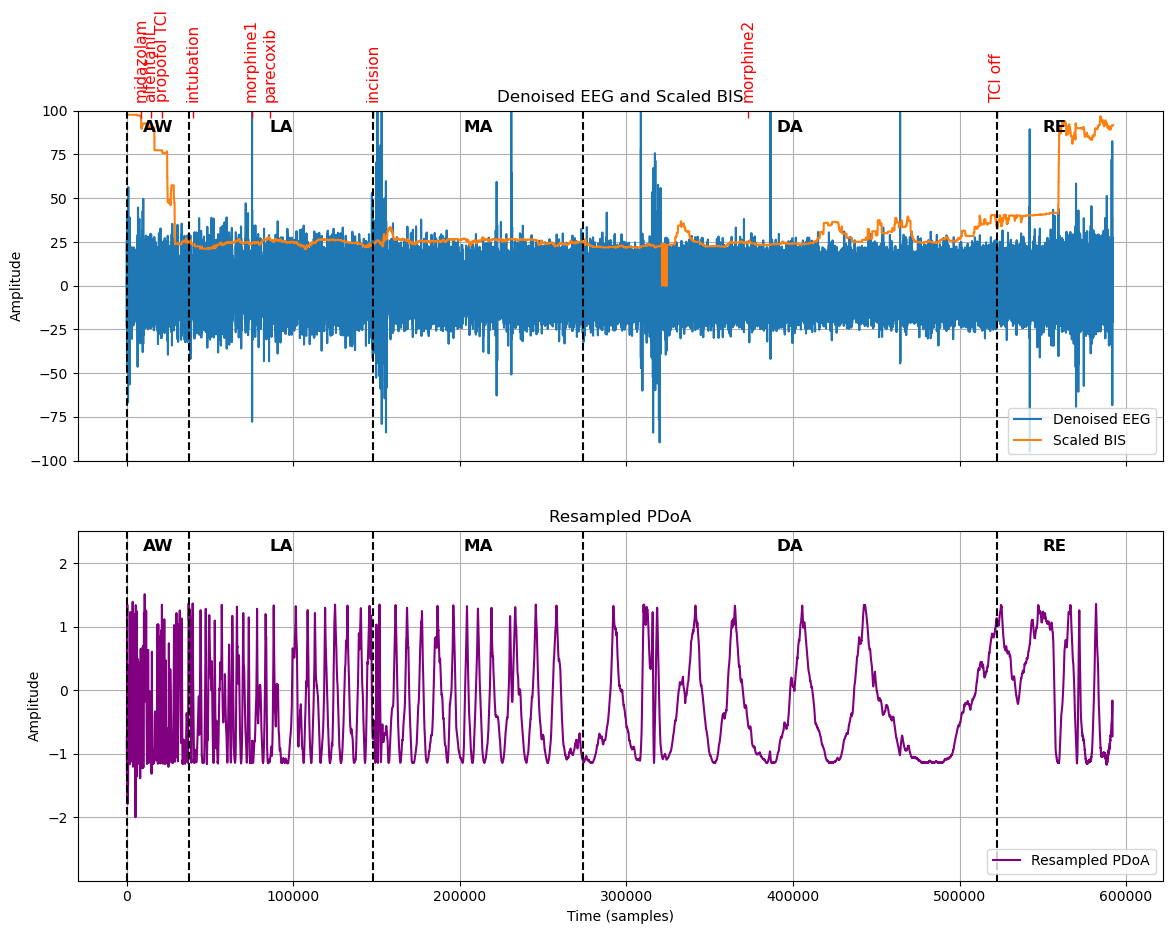

In [18]:
event_times = {
    "midazolam": "10:16:05",
    "alfentanil": "10:16:51",
    "propofol TCI": "10:17:47",
    "intubation": "10:20:08",
    "morphine1": "10:24:45",
    "parecoxib": "10:26:13",
    "incision": "10:34:16",
    "morphine2": "11:03:35",
    "TCI off": "11:23:00"
}

time_seconds = {}
start_time = "10:15:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L06101015, label='Denoised EEG')
axs[0].plot(bis_L06101015, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L06101015, label='Resampled PDoA', color='purple')
axs[1].set_ylim(min(pdoa_resampled) - 1, max(pdoa_resampled) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L06101015_label = [
    (0, 37120, 'AW'),
    (37120, 147968, 'LA'),
    (147968, 273920, 'MA'),
    (273920, 522240, 'DA'),
    (522240, eeg_length, 'RE')
]

for start, end, label in L06101015_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [51]:
# Calculate entropy for each anesthesia state
for start, end, label in L06101015_label:
    state_eeg = eeg_L06101015['eeg'][start:end]
    entropy = shannon_entropy(state_eeg)
    print(f'{label} Entropy: {entropy}')

AW Entropy: 1.5423698381648425
LA Entropy: 0.9473163426868804
MA Entropy: 0.8387943641632684
DA Entropy: 0.8319032929642697
RE Entropy: 1.1850778382343161


/Users/pdmnhtrang/anaconda3/lib/python3.11/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


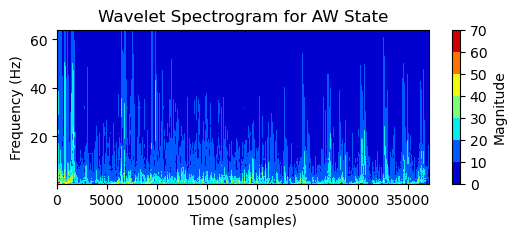

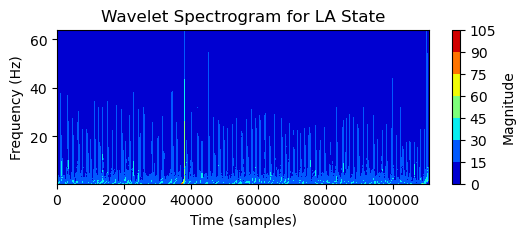

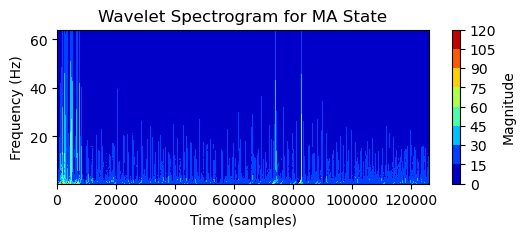

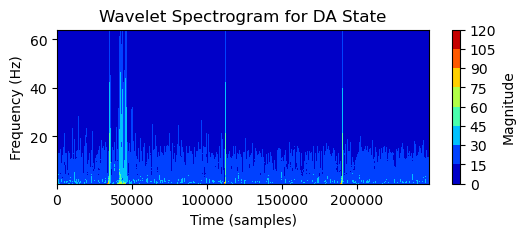

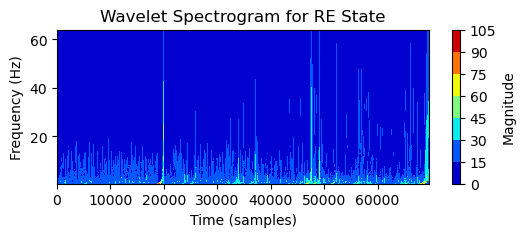

In [80]:
# Plot the wavelet spectrogram for each state
for start, end, label in L06101015_label:
    state_eeg = eeg_L06101015['eeg'][start:end].values
    plot_wavelet_spectrogram(state_eeg, scales, label=label)

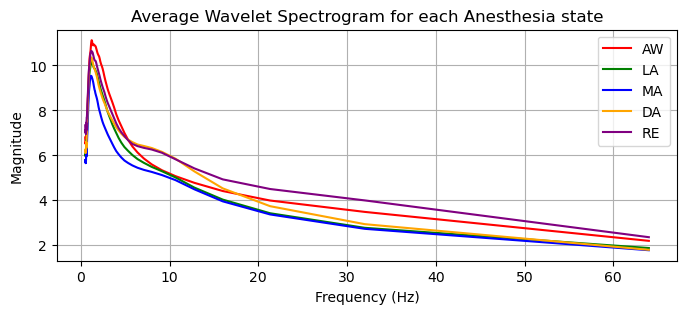

In [81]:
plt.figure(figsize=(8, 3))
colors = ['red', 'green', 'blue', 'orange', 'purple']

#Plot Average wavelet spectrogram for each state
for idx, (start, end, label) in enumerate(L06101015_label):
    state_eeg = eeg_L06101015['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    plt.plot(frequencies, avg_coefficients, color=colors[idx], label=label)

plt.title('Average Wavelet Spectrogram for each Anesthesia state')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [82]:
bis_time = np.linspace(0, len(eeg_L06101015), num=len(bis_L06101015), endpoint=False)
interp_func = interp1d(bis_time, bis_L06101015, kind='linear', fill_value='extrapolate')
bis_resampled = interp_func(np.arange(len(eeg_L06101015)))

average_bis = []

for start, end, label in L06101015_label:
    avg_bis = np.mean(bis_resampled[start:end])
    average_bis.append(avg_bis)
    print(f'{label} Average BIS: {avg_bis}')

AW Average BIS: 69.87774394733465
LA Average BIS: 24.411711006798033
MA Average BIS: 25.674163001266212
DA Average BIS: 26.561112900288226
RE Average BIS: 63.084306056075604


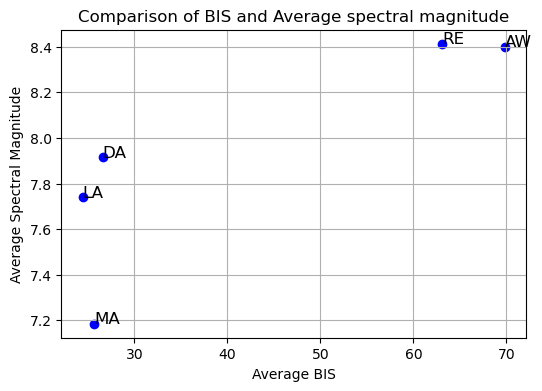

In [83]:
import matplotlib.pyplot as plt

average_spectral_magnitude = []

for start, end, label in L06101015_label:
    state_eeg = eeg_L06101015['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    average_spectral_magnitude.append(np.mean(avg_coefficients))  # Averaging spectral magnitude over frequencies

# Plotting BIS vs Magnitude
plt.figure(figsize = (6, 4))
plt.scatter(average_bis, average_spectral_magnitude, color='blue')
for i, label in enumerate([state[2] for state in L06101015_label]):
    plt.text(average_bis[i], average_spectral_magnitude[i], label, fontsize=12)

plt.xlabel('Average BIS')
plt.ylabel('Average Spectral Magnitude')
plt.title('Comparison of BIS and Average spectral magnitude')
plt.grid(True)
plt.show()

In [33]:
eeg_segments = []
labels = []

for start, end, label in L06101015_label:
    eeg_segment = eeg_L06101015['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L06101015_eeg_label.csv', index=False)

In [103]:
# Extract BIS with label
L06101015_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L06101015_label:
    bis_values = bis_L06101015[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L06101015_bis_label = pd.concat([L06101015_bis_label, bis_segment_df], ignore_index=True)

L06101015_bis_label.to_csv('bis_label/L06101015_label.csv', index=False)

### L06181302

In [19]:
#EEG
L06181302 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L06181302.mat')

eeg_L06181302 = L06181302['xh']
eeg_L06181302 = pd.DataFrame(eeg_L06181302)
eeg_L06181302 = eeg_L06181302.stack().reset_index(drop = True).to_frame()
eeg_L06181302.columns = ['eeg']

#BIS
bis_L06181302 = np.repeat(bis['BIS_L06181302'].dropna().values, 128)

#PDOA
pdoa_L06181302 = pd.read_csv('pdoa/06181302.csv', header = None)
pdoa_L06181302.columns = ['X', 'pdoa']

eeg_length = len(eeg_L06181302)
pdoa_resampled = scipy.signal.resample(pdoa_L06181302['pdoa'], eeg_length)
pdoa_L06181302 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

In [20]:
#Normalise
pdoa_L06181302['pdoa'] = (pdoa_L06181302['pdoa'] - pdoa_L06181302['pdoa'].mean()) / pdoa_L06181302['pdoa'].std()

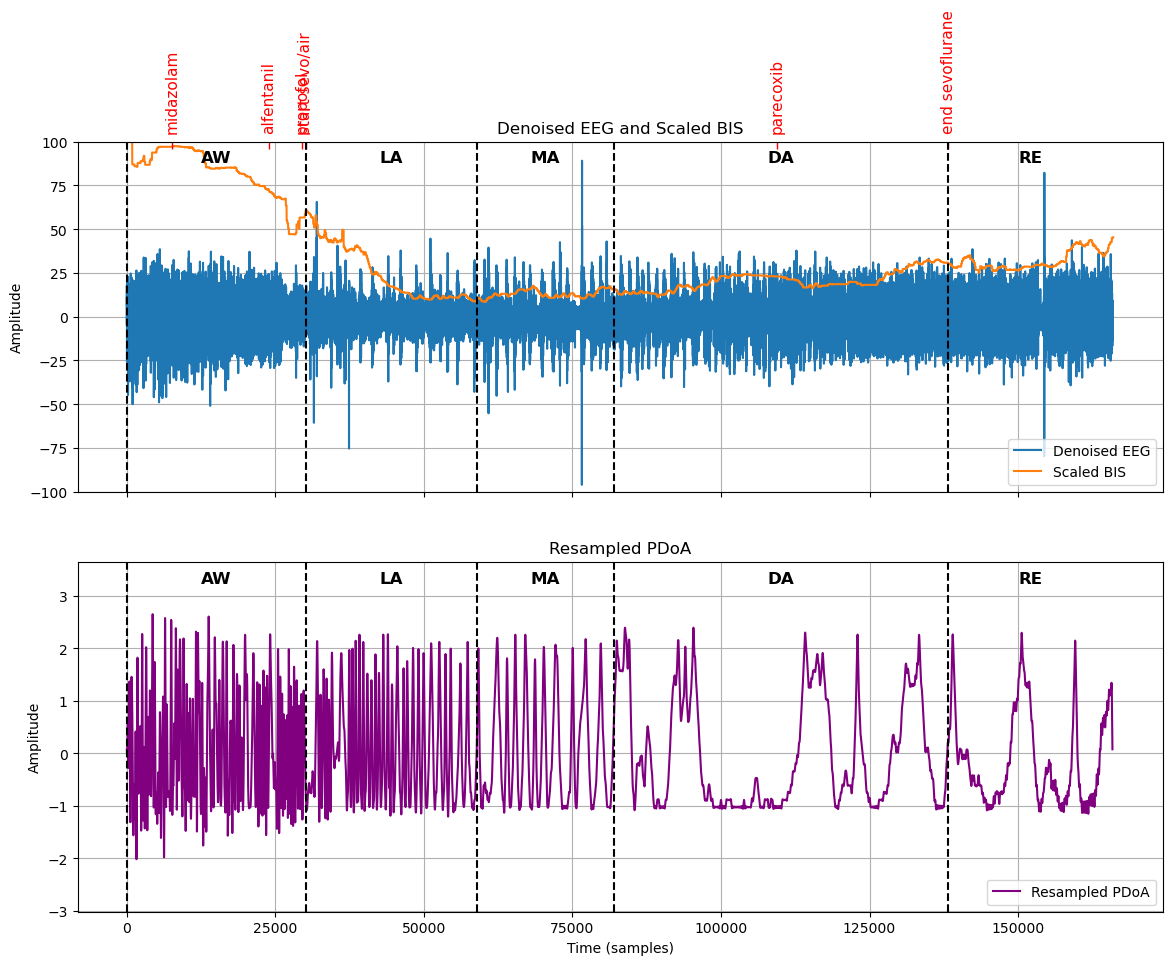

In [21]:
event_times = {
    "midazolam": "13:03:00",
    "alfentanil": "13:05:07",
    "propofol": "13:05:50",
    "start sevo/air": "13:05:55",
    "parecoxib": "13:16:15",
    "end sevoflurane": "13:20:00"
}

time_seconds = {}
start_time = "13:02:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L06181302, label='Denoised EEG')
axs[0].plot(bis_L06181302, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L06181302, label='Resampled PDoA', color='purple')
axs[1].set_ylim(np.min(pdoa_L06181302) - 1, np.max(pdoa_L06181302) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L06181302_label = [
    (0, 30080, 'AW'),
    (30080, 58880, 'LA'),
    (58880, 81920, 'MA'),
    (81920, 138240, 'DA'),
    (138240, eeg_length, 'RE')
]

for start, end, label in L06181302_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [55]:
# Calculate entropy for each anesthesia state
for start, end, label in L06181302_label:
    state_eeg = eeg_L05200708['eeg'][start:end]
    entropy = shannon_entropy(state_eeg)
    print(f'{label} Entropy: {entropy}')

AW Entropy: 1.7171878029648906
LA Entropy: 1.581341659587312
MA Entropy: 1.1501072924090305
DA Entropy: 1.2026096606989303
RE Entropy: 1.0845314459868116


/Users/pdmnhtrang/anaconda3/lib/python3.11/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


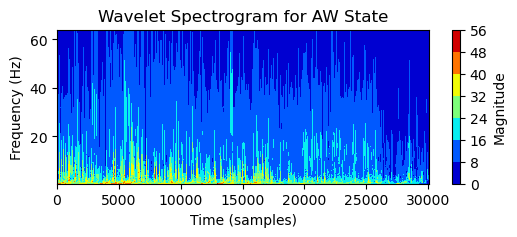

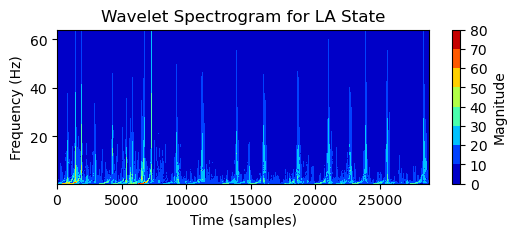

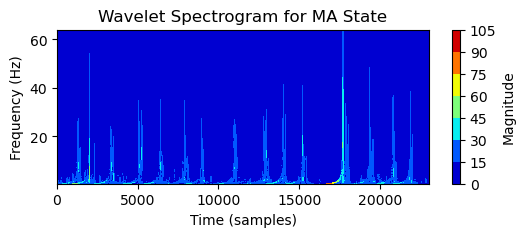

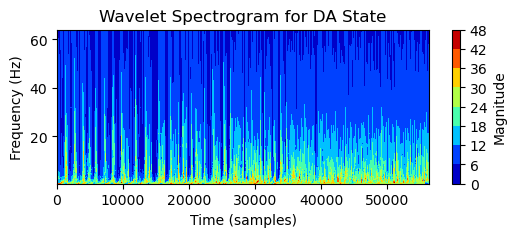

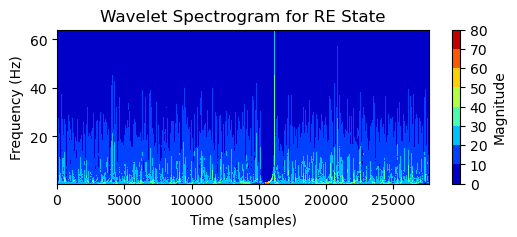

In [88]:
# Plot the wavelet spectrogram for each state
for start, end, label in L06181302_label:
    state_eeg = eeg_L06181302['eeg'][start:end].values
    plot_wavelet_spectrogram(state_eeg, scales, label=label)

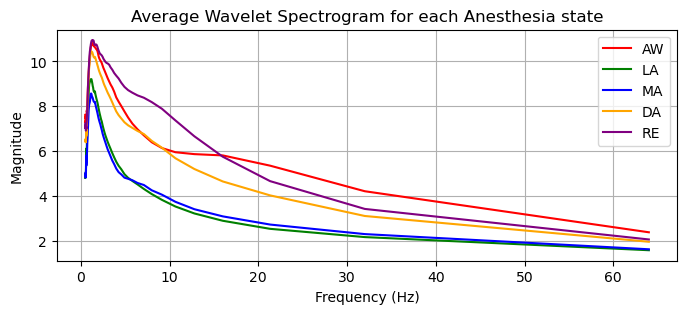

In [89]:
plt.figure(figsize=(8, 3))
colors = ['red', 'green', 'blue', 'orange', 'purple']

#Plot Average wavelet spectrogram for each state
for idx, (start, end, label) in enumerate(L06181302_label):
    state_eeg = eeg_L06181302['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    plt.plot(frequencies, avg_coefficients, color=colors[idx], label=label)

plt.title('Average Wavelet Spectrogram for each Anesthesia state')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [92]:
bis_time = np.linspace(0, len(eeg_L06181302), num=len(bis_L06181302), endpoint=False)
interp_func = interp1d(bis_time, bis_L06181302, kind='linear', fill_value='extrapolate')
bis_resampled = interp_func(np.arange(len(eeg_L06181302)))

average_bis = []

for start, end, label in L06181302_label:
    avg_bis = np.mean(bis_resampled[start:end])
    average_bis.append(avg_bis)
    print(f'{label} Average BIS: {avg_bis}')

AW Average BIS: 82.60679461545712
LA Average BIS: 25.157542673187674
MA Average BIS: 13.02360756438934
DA Average BIS: 20.695464632018037
RE Average BIS: 32.165505774938005


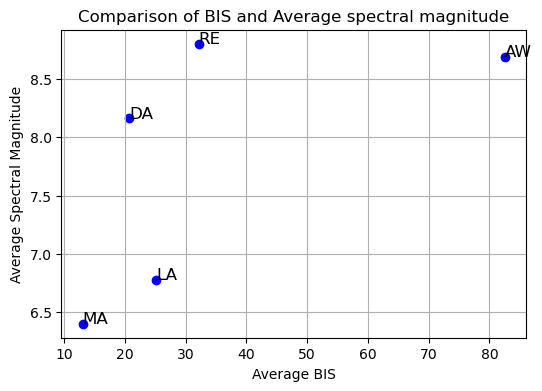

In [93]:
average_spectral_magnitude = []

for start, end, label in L06181302_label:
    state_eeg = eeg_L06181302['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    average_spectral_magnitude.append(np.mean(avg_coefficients))  # Averaging spectral magnitude over frequencies

# Plotting BIS vs Magnitude
plt.figure(figsize = (6, 4))
plt.scatter(average_bis, average_spectral_magnitude, color='blue')
for i, label in enumerate([state[2] for state in L06181302_label]):
    plt.text(average_bis[i], average_spectral_magnitude[i], label, fontsize=12)

plt.xlabel('Average BIS')
plt.ylabel('Average Spectral Magnitude')
plt.title('Comparison of BIS and Average spectral magnitude')
plt.grid(True)
plt.show()

In [37]:
eeg_segments = []
labels = []

for start, end, label in L06181302_label:
    eeg_segment = eeg_L06181302['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L06181302_eeg_label.csv', index=False)

In [104]:
# Extract BIS with label
L06181302_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L06181302_label:
    bis_values = bis_L06181302[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L06181302_bis_label = pd.concat([L06181302_bis_label, bis_segment_df], ignore_index=True)

L06181302_bis_label.to_csv('bis_label/L06181302_label.csv', index=False)

### L06181332

In [22]:
#EEG
L06181332 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L06181332.mat')

eeg_L06181332 = L06181332['xh']
eeg_L06181332 = pd.DataFrame(eeg_L06181332)
eeg_L06181332 = eeg_L06181332.stack().reset_index(drop = True).to_frame()
eeg_L06181332.columns = ['eeg']

#BIS
bis_L06181332 = np.repeat(bis['BIS_L06181332'].dropna().values, 128)

#PDOA
pdoa_L06181332 = pd.read_csv('pdoa/06181332.csv', header = None)
pdoa_L06181332.columns = ['X', 'pdoa']

eeg_length = len(eeg_L06181332)
pdoa_resampled = scipy.signal.resample(pdoa_L06181332['pdoa'], eeg_length)
pdoa_L06181332 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

In [23]:
#Normalise
pdoa_L06181332['pdoa'] = (pdoa_L06181332['pdoa'] - pdoa_L06181332['pdoa'].mean()) / pdoa_L06181332['pdoa'].std()

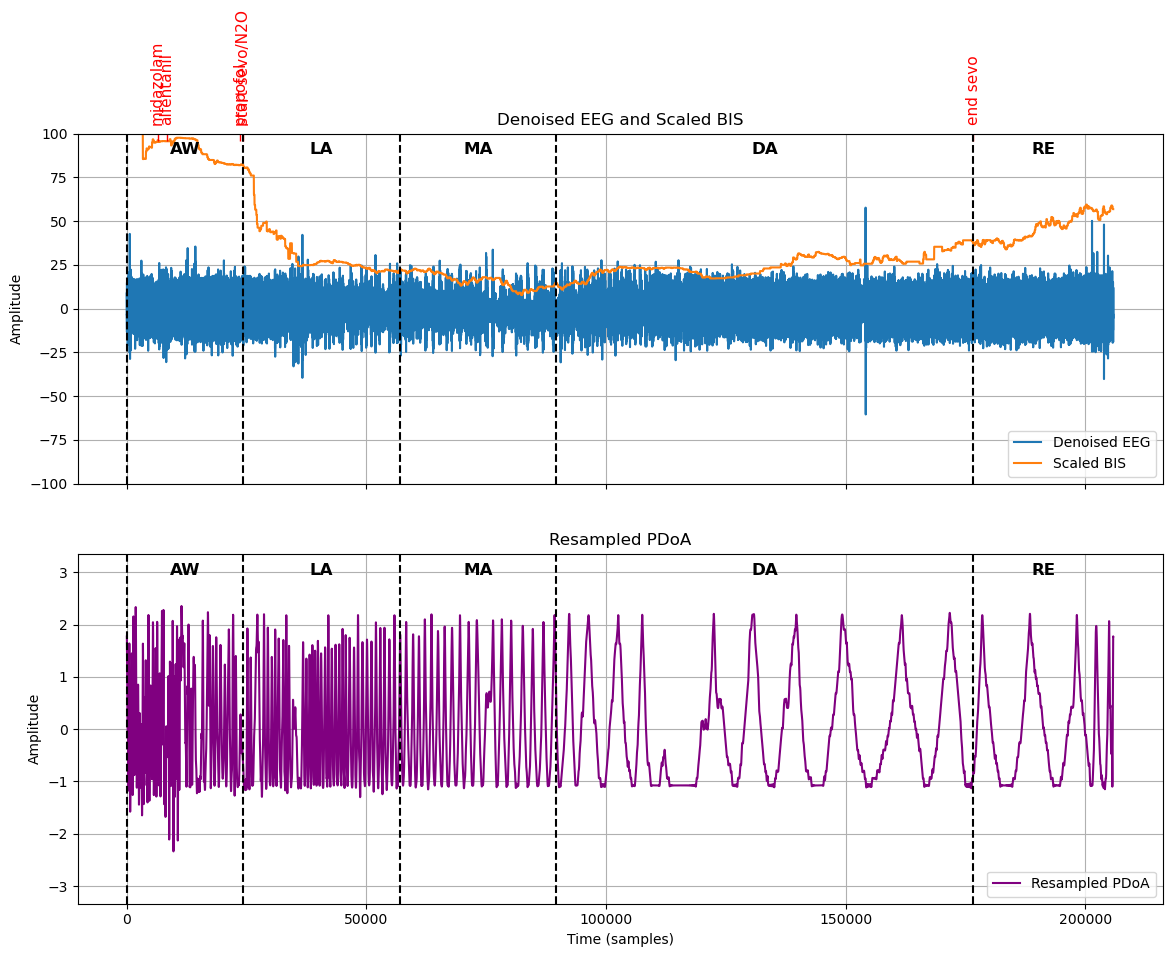

In [24]:
event_times = {
    "midazolam": "13:32:50",
    "alfentanil": "13:33:05",
    "propofol": "13:35:05",
    "start sevo/N2O": "13:35:10",
    "end sevo": "13:55:00"
}

time_seconds = {}
start_time = "13:32:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L06181332, label='Denoised EEG')
axs[0].plot(bis_L06181332, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L06181332, label='Resampled PDoA', color='purple')
axs[1].set_ylim(np.min(pdoa_L06181332) - 1, np.max(pdoa_L06181332) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L06181332_label = [
    (0, 24320, 'AW'),
    (24320, 56960, 'LA'),
    (56960, 89600, 'MA'),
    (89600, 176640, 'DA'),
    (176640, eeg_length, 'RE')
]

for start, end, label in L06181332_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [59]:
# Calculate entropy for each anesthesia state
for start, end, label in L06181332_label:
    state_eeg = eeg_L06181332['eeg'][start:end]
    entropy = shannon_entropy(state_eeg)
    print(f'{label} Entropy: {entropy}')

AW Entropy: 2.036045308877089
LA Entropy: 1.6895439999751913
MA Entropy: 1.8364120051763915
DA Entropy: 1.3371962231004244
RE Entropy: 1.7313914397005878


/Users/pdmnhtrang/anaconda3/lib/python3.11/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


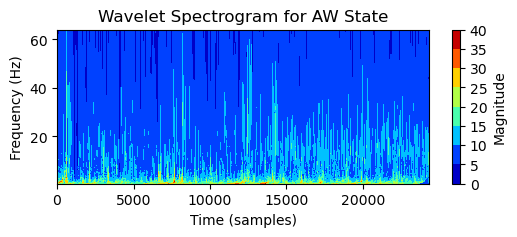

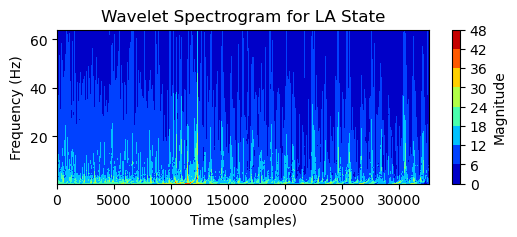

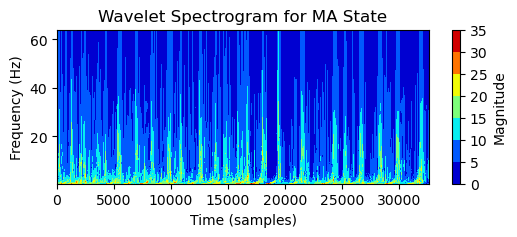

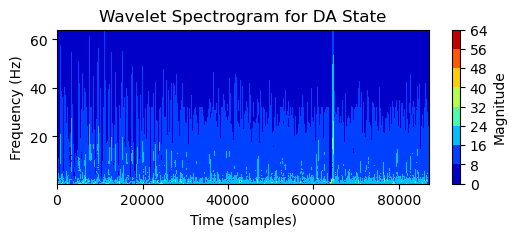

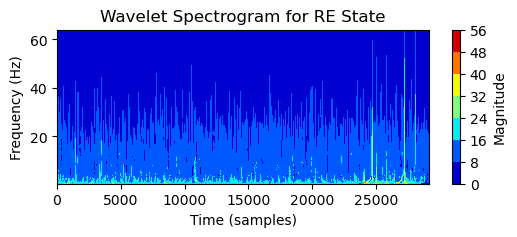

In [98]:
# Plot the wavelet spectrogram for each state
for start, end, label in L06181332_label:
    state_eeg = eeg_L06181332['eeg'][start:end].values
    plot_wavelet_spectrogram(state_eeg, scales, label=label)

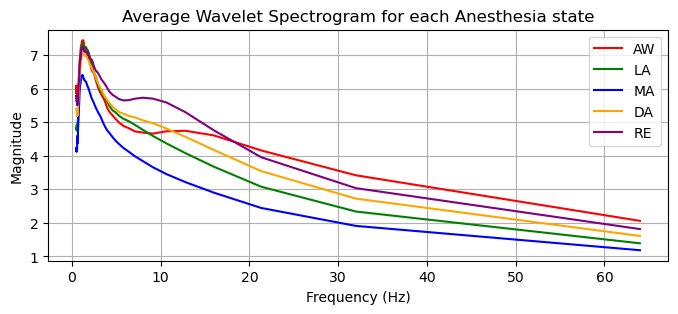

In [99]:
plt.figure(figsize=(8, 3))
colors = ['red', 'green', 'blue', 'orange', 'purple']

#Plot Average wavelet spectrogram for each state
for idx, (start, end, label) in enumerate(L06181332_label):
    state_eeg = eeg_L06181332['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    plt.plot(frequencies, avg_coefficients, color=colors[idx], label=label)

plt.title('Average Wavelet Spectrogram for each Anesthesia state')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [100]:
bis_time = np.linspace(0, len(eeg_L06181332), num=len(bis_L06181332), endpoint=False)
interp_func = interp1d(bis_time, bis_L06181332, kind='linear', fill_value='extrapolate')
bis_resampled = interp_func(np.arange(len(eeg_L06181332)))

average_bis = []

for start, end, label in L06181332_label:
    avg_bis = np.mean(bis_resampled[start:end])
    average_bis.append(avg_bis)
    print(f'{label} Average BIS: {avg_bis}')

AW Average BIS: 91.73468274737752
LA Average BIS: 32.867974600942695
MA Average BIS: 16.205024594441415
DA Average BIS: 24.61855699845639
RE Average BIS: 46.16122549389792


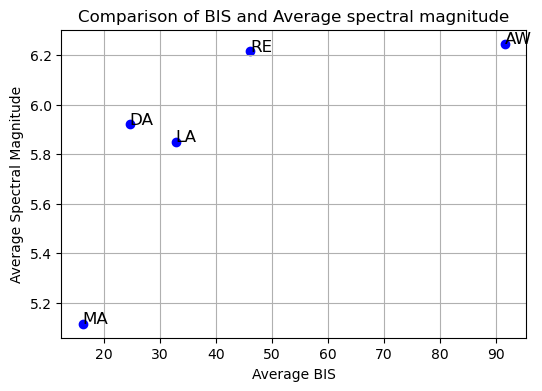

In [101]:
average_spectral_magnitude = []

for start, end, label in L06181332_label:
    state_eeg = eeg_L06181332['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    average_spectral_magnitude.append(np.mean(avg_coefficients))  # Averaging spectral magnitude over frequencies

# Plotting BIS vs Magnitude
plt.figure(figsize = (6, 4))
plt.scatter(average_bis, average_spectral_magnitude, color='blue')
for i, label in enumerate([state[2] for state in L06181332_label]):
    plt.text(average_bis[i], average_spectral_magnitude[i], label, fontsize=12)

plt.xlabel('Average BIS')
plt.ylabel('Average Spectral Magnitude')
plt.title('Comparison of BIS and Average spectral magnitude')
plt.grid(True)
plt.show()

In [41]:
eeg_segments = []
labels = []

for start, end, label in L06181332_label:
    eeg_segment = eeg_L06181332['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L06181332_eeg_label.csv', index=False)

In [105]:
# Extract BIS with label
L06181332_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L06181332_label:
    bis_values = bis_L06181332[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L06181332_bis_label = pd.concat([L06181332_bis_label, bis_segment_df], ignore_index=True)

L06181332_bis_label.to_csv('bis_label/L06181332_label.csv', index=False)

### L06221009

In [25]:
#EEG
L06221009 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L06221009.mat')

eeg_L06221009 = L06221009['xh']
eeg_L06221009 = pd.DataFrame(eeg_L06221009)
eeg_L06221009 = eeg_L06221009.stack().reset_index(drop = True).to_frame()
eeg_L06221009.columns = ['eeg']

#BIS
bis_L06221009 = np.repeat(bis['BISL06221009'].dropna().values, 128)

#PDOA
pdoa_L06221009 = pd.read_csv('pdoa/06221009.csv', header = None)
pdoa_L06221009.columns = ['X', 'pdoa']

eeg_length = len(eeg_L06221009)
pdoa_resampled = scipy.signal.resample(pdoa_L06221009['pdoa'], eeg_length)
pdoa_L06221009 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

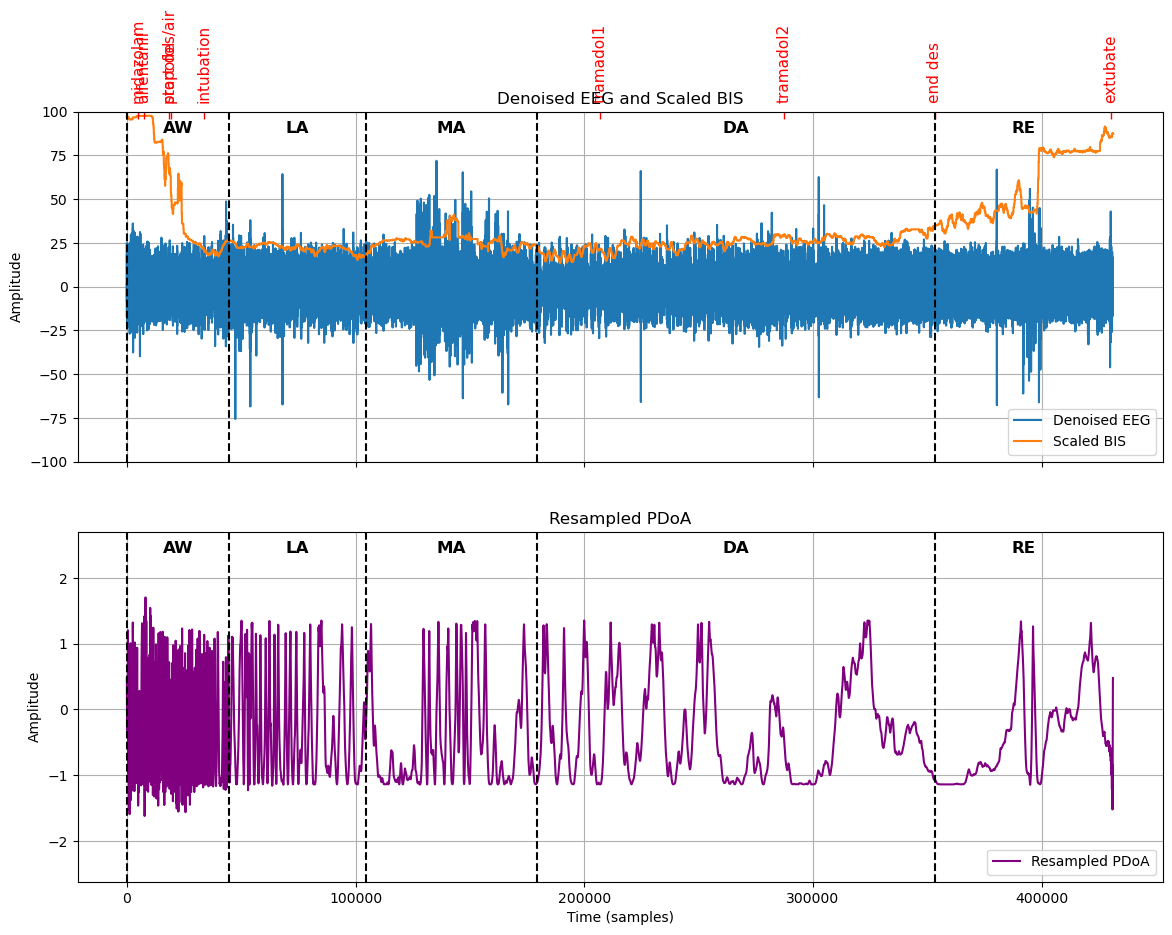

In [26]:
event_times = {
    "midazolam": "10:09:38",
    "alfentanil": "10:09:58",
    "propofol": "10:11:23",
    "start des/air": "10:11:30",
    "intubation": "10:13:24",
    "tramadol1": "10:35:55",
    "tramadol2": "10:46:25",
    "end des": "10:55:00",
    "extubate": "11:05:00"
}

time_seconds = {}
start_time = "10:09:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L06221009, label='Denoised EEG')
axs[0].plot(bis_L06221009, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L06221009, label='Resampled PDoA', color='purple')
axs[1].set_ylim(min(pdoa_resampled) - 1, max(pdoa_resampled) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L06221009_label = [
    (0, 44800, 'AW'),
    (44800, 104500, 'LA'),
    (104500, 179200, 'MA'),
    (179200, 353280, 'DA'),
    (353280, eeg_length, 'RE')
]

for start, end, label in L06221009_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [62]:
# Calculate entropy for each anesthesia state
for start, end, label in L06221009_label:
    state_eeg = eeg_L06221009['eeg'][start:end]
    entropy = shannon_entropy(state_eeg)
    print(f'{label} Entropy: {entropy}')

AW Entropy: 1.744185730652919
LA Entropy: 1.0550446458810558
MA Entropy: 1.2828552504527062
DA Entropy: 1.2759739733724256
RE Entropy: 1.3037531918725442


/Users/pdmnhtrang/anaconda3/lib/python3.11/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


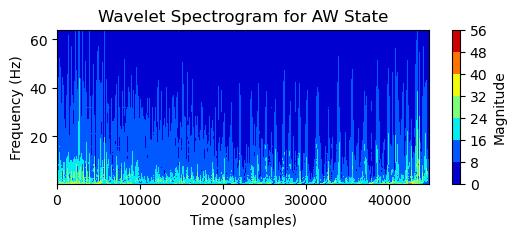

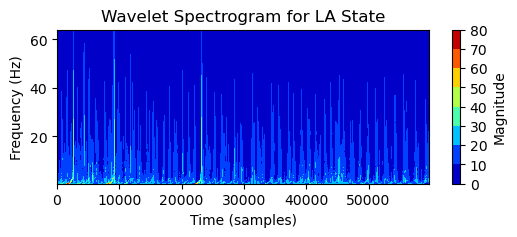

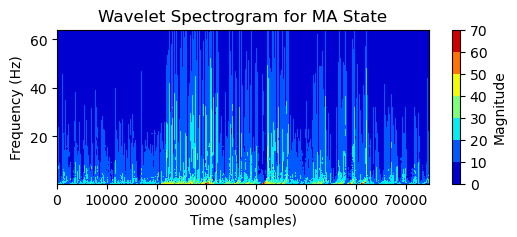

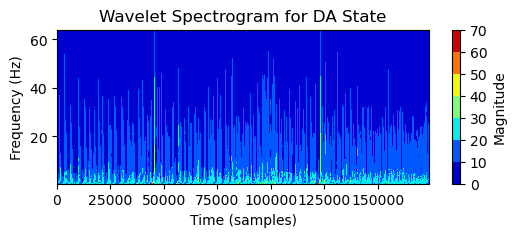

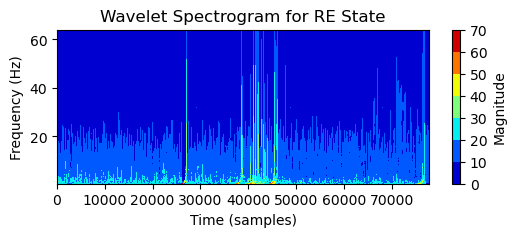

In [105]:
# Plot the wavelet spectrogram for each state
for start, end, label in L06221009_label:
    state_eeg = eeg_L06221009['eeg'][start:end].values
    plot_wavelet_spectrogram(state_eeg, scales, label=label)

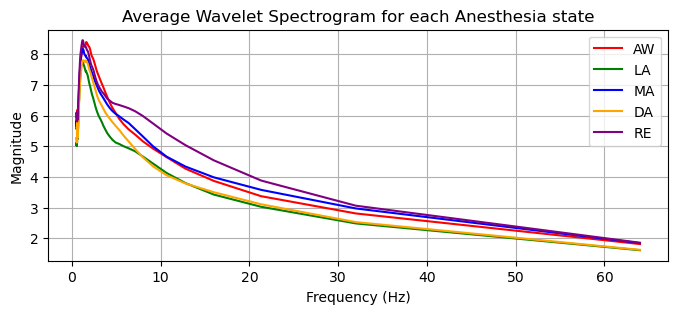

In [106]:
plt.figure(figsize=(8, 3))
colors = ['red', 'green', 'blue', 'orange', 'purple']

#Plot Average wavelet spectrogram for each state
for idx, (start, end, label) in enumerate(L06221009_label):
    state_eeg = eeg_L06221009['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    plt.plot(frequencies, avg_coefficients, color=colors[idx], label=label)

plt.title('Average Wavelet Spectrogram for each Anesthesia state')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [107]:
bis_time = np.linspace(0, len(eeg_L06221009), num=len(bis_L06221009), endpoint=False)
interp_func = interp1d(bis_time, bis_L06221009, kind='linear', fill_value='extrapolate')
bis_resampled = interp_func(np.arange(len(eeg_L06221009)))

average_bis = []

for start, end, label in L06221009_label:
    avg_bis = np.mean(bis_resampled[start:end])
    average_bis.append(avg_bis)
    print(f'{label} Average BIS: {avg_bis}')

AW Average BIS: 54.5892792854173
LA Average BIS: 22.162720522373498
MA Average BIS: 26.085137277921273
DA Average BIS: 24.89384180072541
RE Average BIS: 57.33156930317357


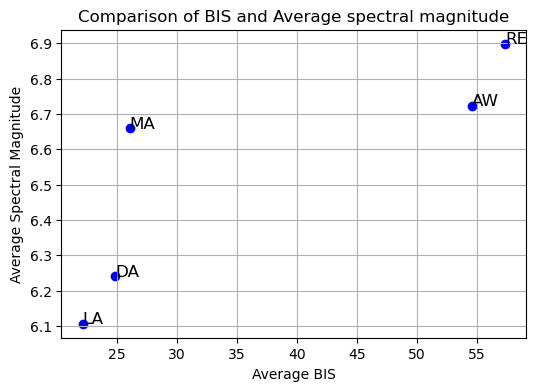

In [108]:
average_spectral_magnitude = []

for start, end, label in L06221009_label:
    state_eeg = eeg_L06221009['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    average_spectral_magnitude.append(np.mean(avg_coefficients))  # Averaging spectral magnitude over frequencies

# Plotting BIS vs Magnitude
plt.figure(figsize = (6, 4))
plt.scatter(average_bis, average_spectral_magnitude, color='blue')
for i, label in enumerate([state[2] for state in L06221009_label]):
    plt.text(average_bis[i], average_spectral_magnitude[i], label, fontsize=12)

plt.xlabel('Average BIS')
plt.ylabel('Average Spectral Magnitude')
plt.title('Comparison of BIS and Average spectral magnitude')
plt.grid(True)
plt.show()

In [44]:
eeg_segments = []
labels = []

for start, end, label in L06221009_label:
    eeg_segment = eeg_L06221009['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L06221009_eeg_label.csv', index=False)

In [106]:
# Extract BIS with label
L06221009_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L06221009_label:
    bis_values = bis_L06221009[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L06221009_bis_label = pd.concat([L06221009_bis_label, bis_segment_df], ignore_index=True)

L06221009_bis_label.to_csv('bis_label/L06221009_label.csv', index=False)

### L06221141

In [27]:
#EEG
L06221141 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L06221141.mat')

eeg_L06221141 = L06221141['xh']
eeg_L06221141 = pd.DataFrame(eeg_L06221141)
eeg_L06221141 = eeg_L06221141.stack().reset_index(drop = True).to_frame()
eeg_L06221141.columns = ['eeg']

#BIS
bis_L06221141 = np.repeat(bis['BIS_L06221141'].dropna().values, 128)

#PDOA
pdoa_L06221141 = pd.read_csv('pdoa/06221141.csv', header = None)
pdoa_L06221141.columns = ['X', 'pdoa']

eeg_length = len(eeg_L06221141)
pdoa_resampled = scipy.signal.resample(pdoa_L06221141['pdoa'], eeg_length)
pdoa_L06221141 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

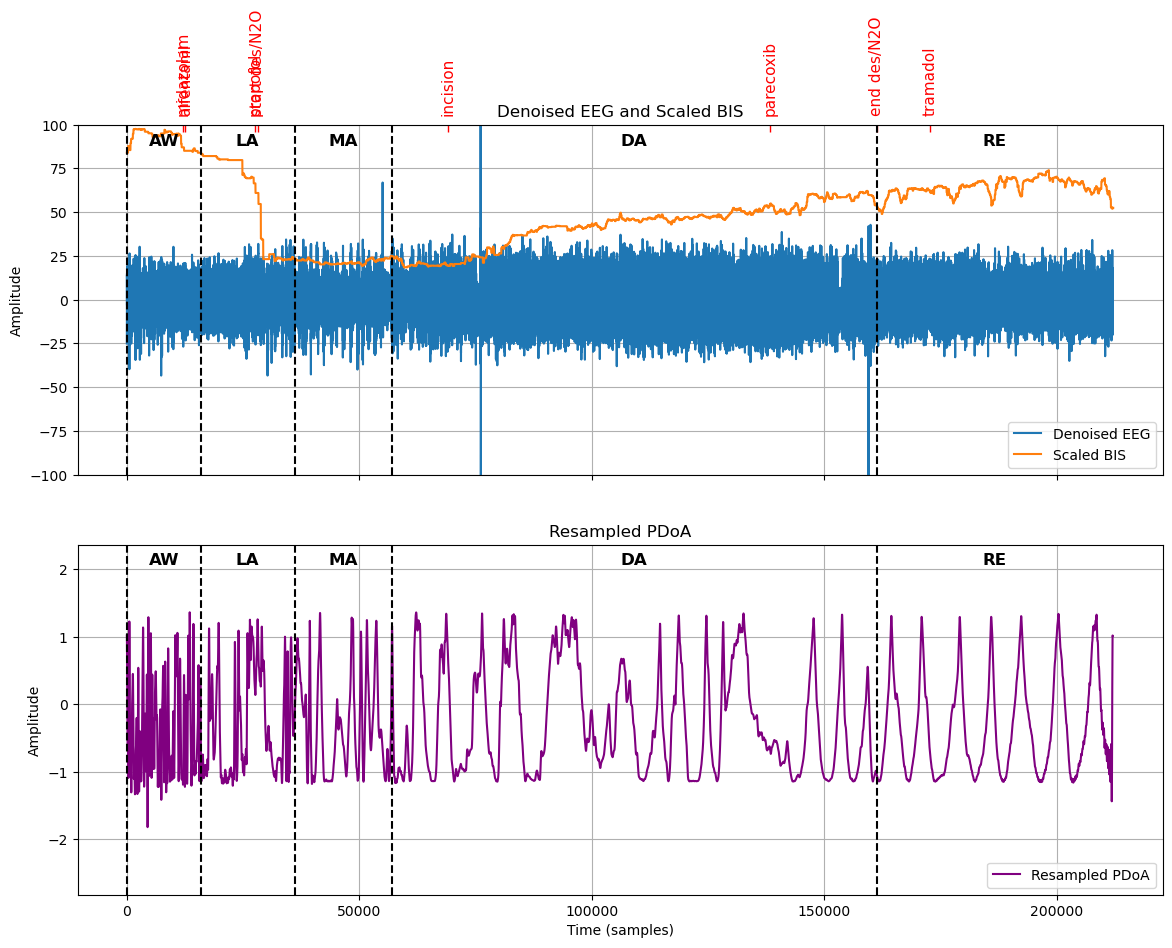

In [28]:
event_times = {
    "midazolam": "11:42:35",
    "alfentanil": "11:42:38",
    "propofol": "11:44:35",
    "start des/N2O": "11:44:40",
    "incision": "11:50:00",
    "parecoxib": "11:59:00",
    "end des/N2O": "12:02:00",
    "tramadol": "12:03:30"
}

time_seconds = {}
start_time = "11:41:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L06221141, label='Denoised EEG')
axs[0].plot(bis_L06221141, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L06221141, label='Resampled PDoA', color='purple')
axs[1].set_ylim(min(pdoa_resampled) - 1, max(pdoa_resampled) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L06221141_label = [
    (0, 15872, 'AW'),
    (15872, 36096, 'LA'),
    (36096, 56960, 'MA'),
    (56960, 161280, 'DA'),
    (161280, eeg_length, 'RE')
]

for start, end, label in L06221141_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [65]:
# Calculate entropy for each anesthesia state
for start, end, label in L06221141_label:
    state_eeg = eeg_L06221141['eeg'][start:end]
    entropy = shannon_entropy(state_eeg)
    print(f'{label} Entropy: {entropy}')

AW Entropy: 2.072558547381428
LA Entropy: 2.0568721767687683
MA Entropy: 1.619761321297892
DA Entropy: 1.1042545537314146
RE Entropy: 2.2766884282063833


/Users/pdmnhtrang/anaconda3/lib/python3.11/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


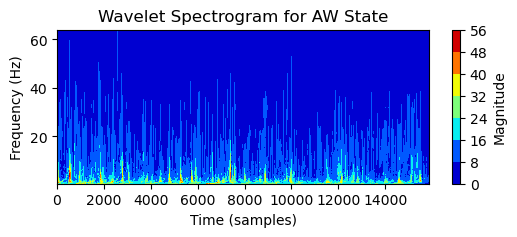

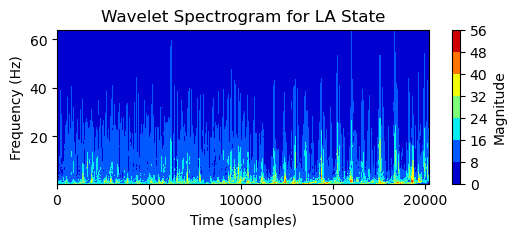

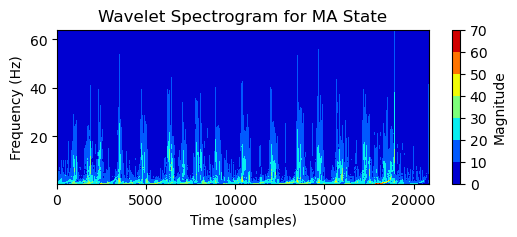

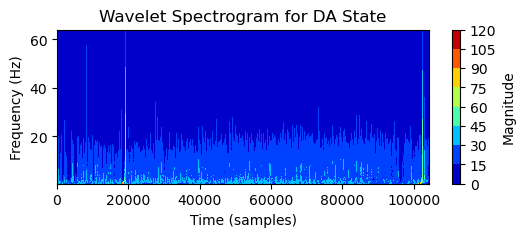

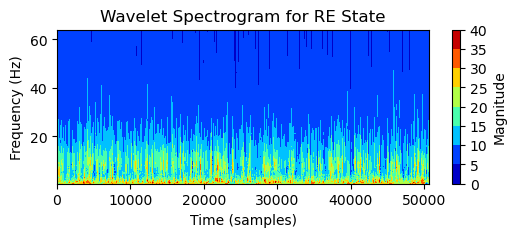

In [112]:
# Plot the wavelet spectrogram for each state
for start, end, label in L06221141_label:
    state_eeg = eeg_L06221141['eeg'][start:end].values
    plot_wavelet_spectrogram(state_eeg, scales, label=label)

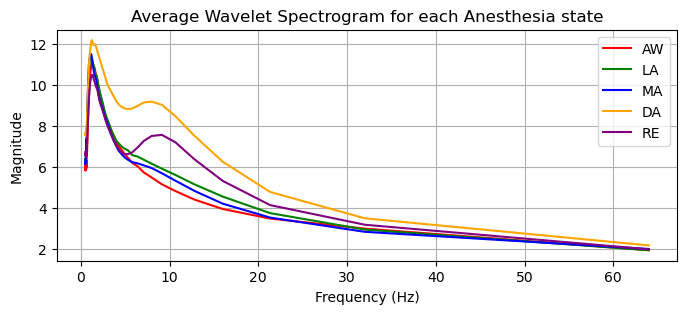

In [113]:
plt.figure(figsize=(8, 3))
colors = ['red', 'green', 'blue', 'orange', 'purple']

#Plot Average wavelet spectrogram for each state
for idx, (start, end, label) in enumerate(L06221141_label):
    state_eeg = eeg_L06221141['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    plt.plot(frequencies, avg_coefficients, color=colors[idx], label=label)

plt.title('Average Wavelet Spectrogram for each Anesthesia state')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [114]:
bis_time = np.linspace(0, len(eeg_L06221141), num=len(bis_L06221141), endpoint=False)
interp_func = interp1d(bis_time, bis_L06221141, kind='linear', fill_value='extrapolate')
bis_resampled = interp_func(np.arange(len(eeg_L06221141)))

average_bis = []

for start, end, label in L06221141_label:
    avg_bis = np.mean(bis_resampled[start:end])
    average_bis.append(avg_bis)
    print(f'{label} Average BIS: {avg_bis}')

AW Average BIS: 92.14826705175106
LA Average BIS: 57.60476055953027
MA Average BIS: 21.754940093641874
DA Average BIS: 42.087671751973545
RE Average BIS: 64.270307824013


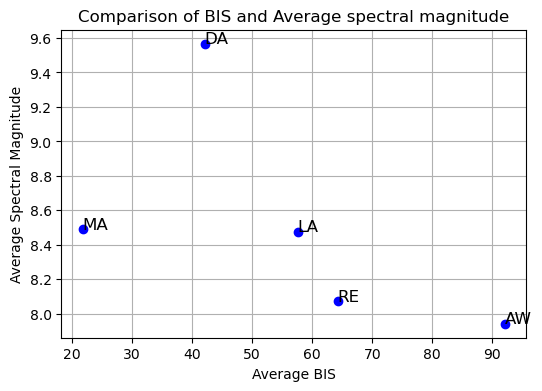

In [115]:
average_spectral_magnitude = []

for start, end, label in L06221141_label:
    state_eeg = eeg_L06221141['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    average_spectral_magnitude.append(np.mean(avg_coefficients))  # Averaging spectral magnitude over frequencies

# Plotting BIS vs Magnitude
plt.figure(figsize = (6, 4))
plt.scatter(average_bis, average_spectral_magnitude, color='blue')
for i, label in enumerate([state[2] for state in L06221141_label]):
    plt.text(average_bis[i], average_spectral_magnitude[i], label, fontsize=12)

plt.xlabel('Average BIS')
plt.ylabel('Average Spectral Magnitude')
plt.title('Comparison of BIS and Average spectral magnitude')
plt.grid(True)
plt.show()

In [47]:
eeg_segments = []
labels = []

for start, end, label in L06221141_label:
    eeg_segment = eeg_L06221141['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L06221141_eeg_label.csv', index=False)

In [107]:
# Extract BIS with label
L06221141_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L06221141_label:
    bis_values = bis_L06221141[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L06221141_bis_label = pd.concat([L06221141_bis_label, bis_segment_df], ignore_index=True)

L06221141_bis_label.to_csv('bis_label/L06221141_label.csv', index=False)

### L06221219

In [29]:
#EEG
L06221219 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L06221219.mat')

eeg_L06221219 = L06221219['xh']
eeg_L06221219 = pd.DataFrame(eeg_L06221219)
eeg_L06221219 = eeg_L06221219.stack().reset_index(drop = True).to_frame()
eeg_L06221219.columns = ['eeg']

#BIS
bis_L06221219 = np.repeat(bis['BIS_L06221219'].dropna().values, 128)

#PDOA
pdoa_L06221219 = pd.read_csv('pdoa/06221219.csv', header = None)
pdoa_L06221219.columns = ['X', 'pdoa']

eeg_length = len(eeg_L06221219)
pdoa_resampled = scipy.signal.resample(pdoa_L06221219['pdoa'], eeg_length)
pdoa_L06221219 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

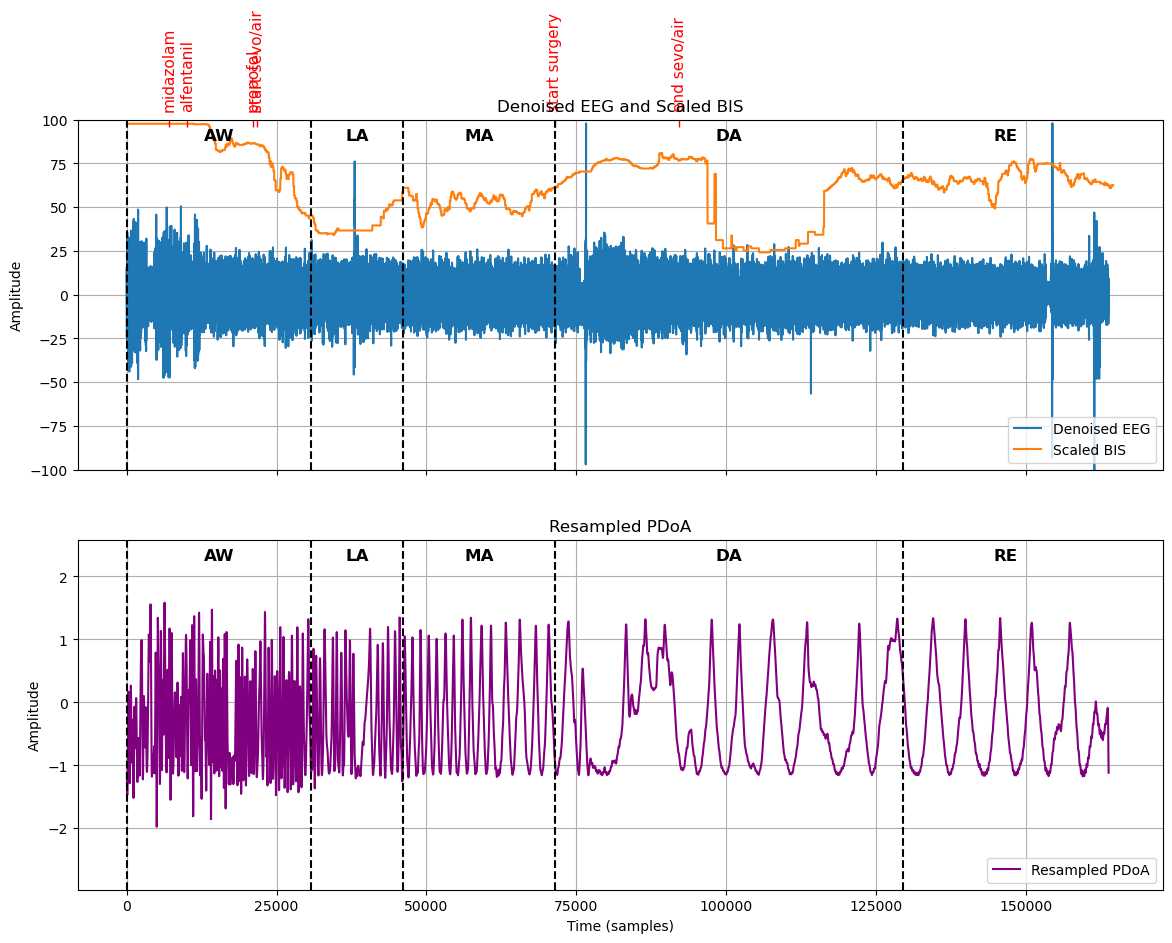

In [30]:
event_times = {
    "midazolam": "12:19:55",
    "alfentanil": "12:20:19",
    "propofol": "12:21:45",
    "start sevo/air": "12:21:50",
    "start surgery": "12:28:18",
    "end sevo/air": "12:31:00"
}

time_seconds = {}
start_time = "12:19:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L06221219, label='Denoised EEG')
axs[0].plot(bis_L06221219, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L06221219, label='Resampled PDoA', color='purple')
axs[1].set_ylim(min(pdoa_resampled) - 1, max(pdoa_resampled) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L06221219_label = [
    (0, 30720, 'AW'),
    (30720, 46080, 'LA'),
    (46080, 71424, 'MA'), #time start surgery
    (71424, 129536, 'DA'),
    (129536, eeg_length, 'RE')
]

for start, end, label in L06221219_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [68]:
# Calculate entropy for each anesthesia state
for start, end, label in L06221219_label:
    state_eeg = eeg_L06221219['eeg'][start:end]
    entropy = shannon_entropy(state_eeg)
    print(f'{label} Entropy: {entropy}')

AW Entropy: 1.9320336280734962
LA Entropy: 1.5109556050227337
MA Entropy: 2.525478130562121
DA Entropy: 1.0949947210217907
RE Entropy: 0.810382356722504


/Users/pdmnhtrang/anaconda3/lib/python3.11/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


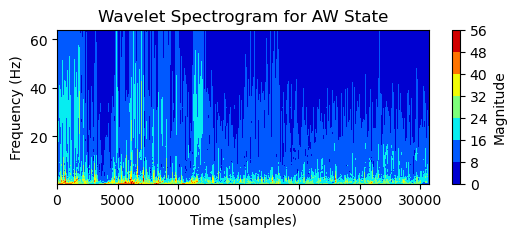

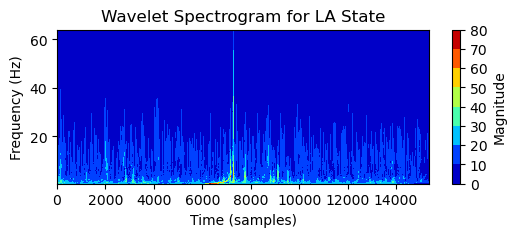

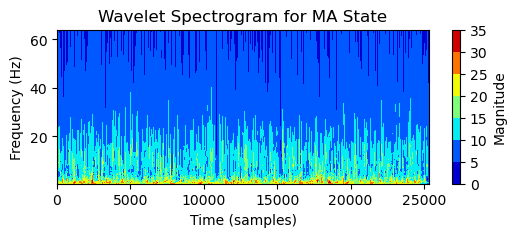

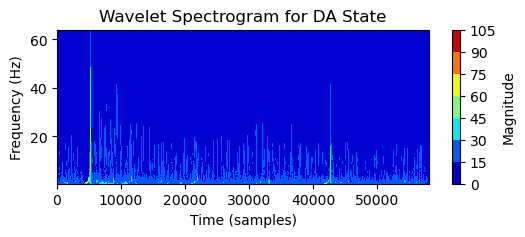

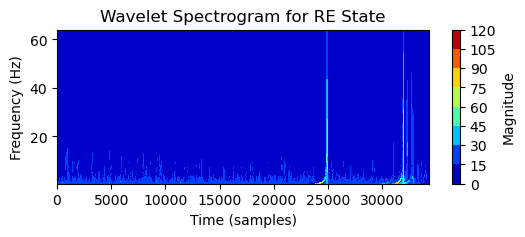

In [119]:
# Plot the wavelet spectrogram for each state
for start, end, label in L06221219_label:
    state_eeg = eeg_L06221219['eeg'][start:end].values
    plot_wavelet_spectrogram(state_eeg, scales, label=label)

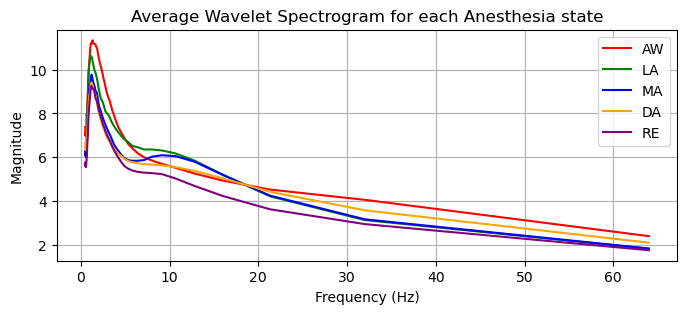

In [120]:
plt.figure(figsize=(8, 3))
colors = ['red', 'green', 'blue', 'orange', 'purple']

#Plot Average wavelet spectrogram for each state
for idx, (start, end, label) in enumerate(L06221219_label):
    state_eeg = eeg_L06221219['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    plt.plot(frequencies, avg_coefficients, color=colors[idx], label=label)

plt.title('Average Wavelet Spectrogram for each Anesthesia state')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [121]:
bis_time = np.linspace(0, len(eeg_L06221219), num=len(bis_L06221219), endpoint=False)
interp_func = interp1d(bis_time, bis_L06221219, kind='linear', fill_value='extrapolate')
bis_resampled = interp_func(np.arange(len(eeg_L06221219)))

average_bis = []

for start, end, label in L06221219_label:
    avg_bis = np.mean(bis_resampled[start:end])
    average_bis.append(avg_bis)
    print(f'{label} Average BIS: {avg_bis}')

AW Average BIS: 85.0330942071188
LA Average BIS: 40.68828834251918
MA Average BIS: 52.932396695098944
DA Average BIS: 57.36598477408823
RE Average BIS: 66.73259071058678


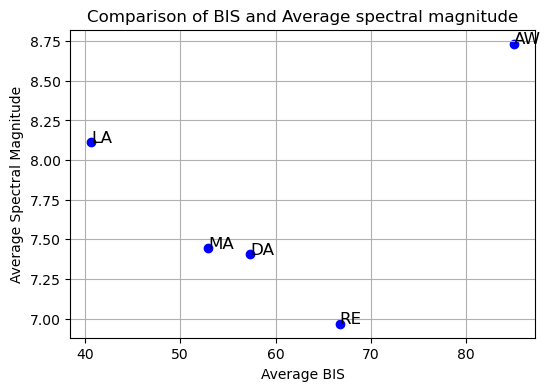

In [122]:
average_spectral_magnitude = []

for start, end, label in L06221219_label:
    state_eeg = eeg_L06221219['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    average_spectral_magnitude.append(np.mean(avg_coefficients))  # Averaging spectral magnitude over frequencies

# Plotting BIS vs Magnitude
plt.figure(figsize = (6, 4))
plt.scatter(average_bis, average_spectral_magnitude, color='blue')
for i, label in enumerate([state[2] for state in L06221219_label]):
    plt.text(average_bis[i], average_spectral_magnitude[i], label, fontsize=12)

plt.xlabel('Average BIS')
plt.ylabel('Average Spectral Magnitude')
plt.title('Comparison of BIS and Average spectral magnitude')
plt.grid(True)
plt.show()

In [50]:
eeg_segments = []
labels = []

for start, end, label in L06221219_label:
    eeg_segment = eeg_L06221219['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L06221219_eeg_label.csv', index=False)

In [108]:
# Extract BIS with label
L06221219_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L06221219_label:
    bis_values = bis_L06221219[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L06221219_bis_label = pd.concat([L06221219_bis_label, bis_segment_df], ignore_index=True)

L06221219_bis_label.to_csv('bis_label/L06221219_label.csv', index=False)

### L08181442

In [31]:
#EEG
L08181442 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L08181442.mat')

eeg_L08181442 = L08181442['xh']
eeg_L08181442 = pd.DataFrame(eeg_L08181442)
eeg_L08181442 = eeg_L08181442.stack().reset_index(drop = True).to_frame()
eeg_L08181442.columns = ['eeg']

#BIS
bis_L08181442 = np.repeat(bis['BIS_L08181442'].dropna().values, 128)

#PDOA
pdoa_L08181442 = pd.read_csv('pdoa/08181442.csv', header = None)
pdoa_L08181442.columns = ['X', 'pdoa']

eeg_length = len(eeg_L08181442)
pdoa_resampled = scipy.signal.resample(pdoa_L08181442['pdoa'], eeg_length)
pdoa_L08181442 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

In [32]:
#Normalise
pdoa_L08181442['pdoa'] = (pdoa_L08181442['pdoa'] - pdoa_L08181442['pdoa'].mean()) / pdoa_L08181442['pdoa'].std()

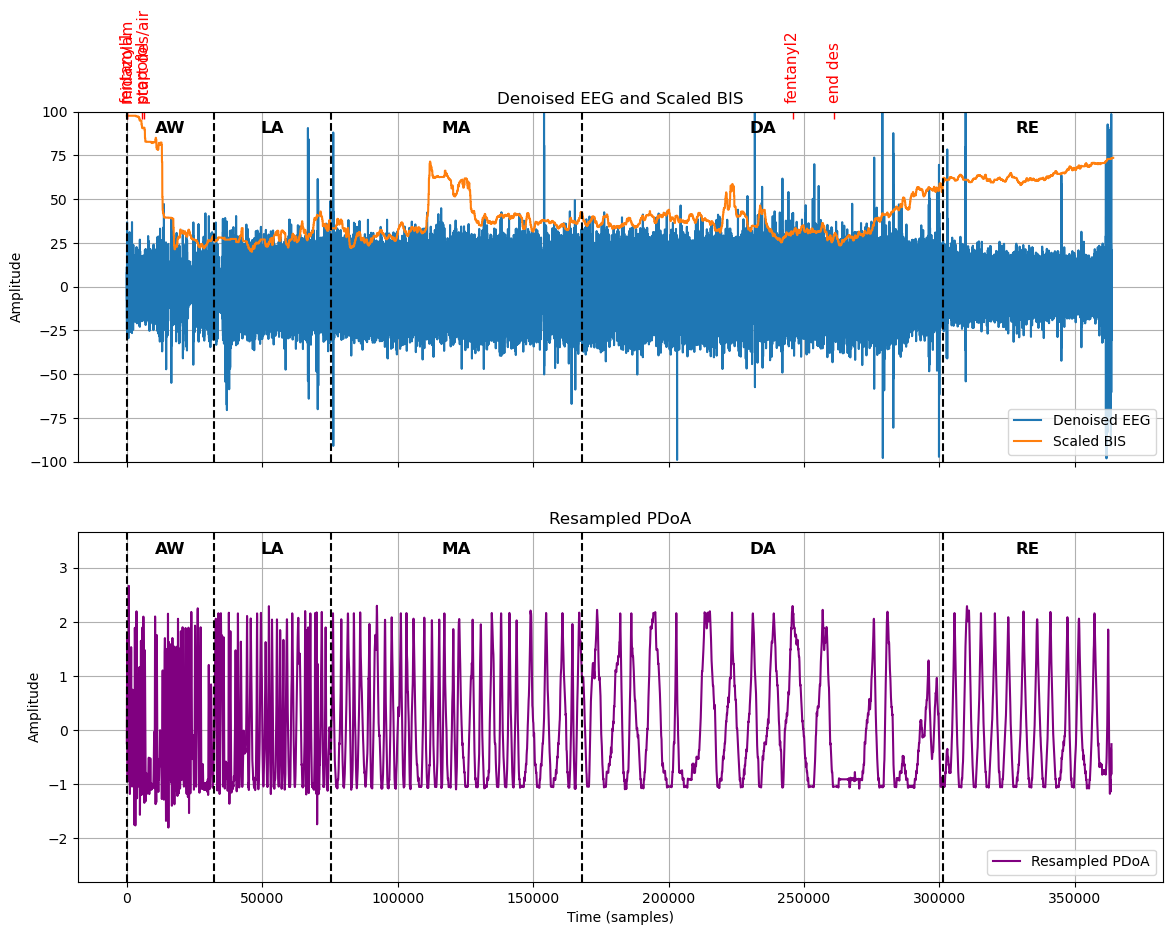

In [33]:
event_times = {
    "midazolam": "14:43:00",
    "fentanyl1": "14:43:00",
    "propofol": "14:43:45",
    "start des/air": "14:43:50",
    "fentanyl2": "15:15:00",
    "end des": "15:17:00"
}

time_seconds = {}
start_time = "14:43:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L08181442, label='Denoised EEG')
axs[0].plot(bis_L08181442, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L08181442, label='Resampled PDoA', color='purple')
axs[1].set_ylim(np.min(pdoa_L08181442) - 1, np.max(pdoa_L08181442) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L08181442_label = [
    (0, 32000, 'AW'),
    (32000, 75520, 'LA'),
    (75520, 168000, 'MA'),
    (168000, 301500, 'DA'),
    (301500, eeg_length, 'RE')
]

for start, end, label in L08181442_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [72]:
# Calculate entropy for each anesthesia state
for start, end, label in L08181442_label:
    state_eeg = eeg_L08181442['eeg'][start:end]
    entropy = shannon_entropy(state_eeg)
    print(f'{label} Entropy: {entropy}')

AW Entropy: 1.7064806078880965
LA Entropy: 1.3908968223634322
MA Entropy: 1.2299819793407072
DA Entropy: 1.1871402504203683
RE Entropy: 0.7753702536069825


/Users/pdmnhtrang/anaconda3/lib/python3.11/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


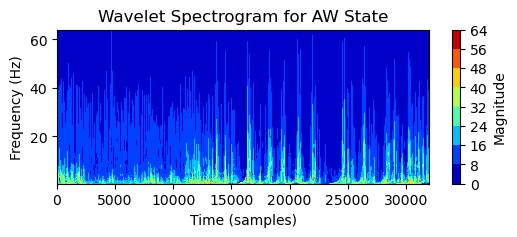

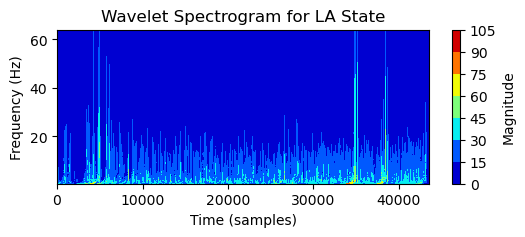

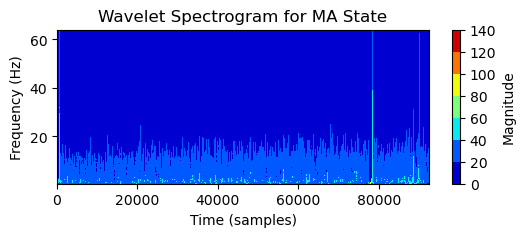

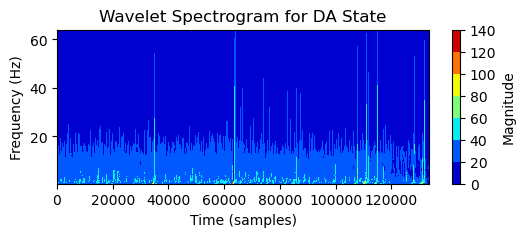

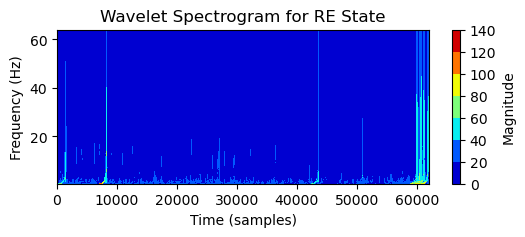

In [127]:
# Plot the wavelet spectrogram for each state
for start, end, label in L08181442_label:
    state_eeg = eeg_L08181442['eeg'][start:end].values
    plot_wavelet_spectrogram(state_eeg, scales, label=label)

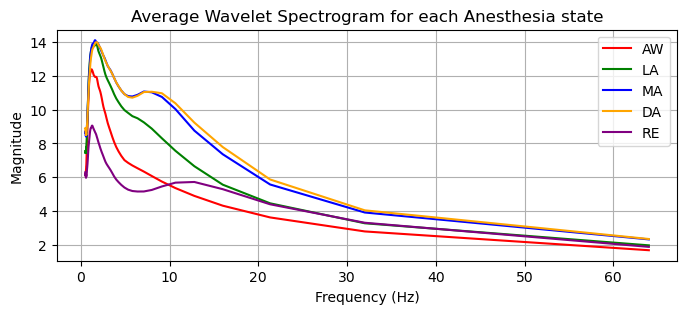

In [128]:
plt.figure(figsize=(8, 3))
colors = ['red', 'green', 'blue', 'orange', 'purple']

#Plot Average wavelet spectrogram for each state
for idx, (start, end, label) in enumerate(L08181442_label):
    state_eeg = eeg_L08181442['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    plt.plot(frequencies, avg_coefficients, color=colors[idx], label=label)

plt.title('Average Wavelet Spectrogram for each Anesthesia state')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [129]:
bis_time = np.linspace(0, len(eeg_L08181442), num=len(bis_L08181442), endpoint=False)
interp_func = interp1d(bis_time, bis_L08181442, kind='linear', fill_value='extrapolate')
bis_resampled = interp_func(np.arange(len(eeg_L08181442)))

average_bis = []

for start, end, label in L08181442_label:
    avg_bis = np.mean(bis_resampled[start:end])
    average_bis.append(avg_bis)
    print(f'{label} Average BIS: {avg_bis}')

AW Average BIS: 53.91973347734231
LA Average BIS: 28.82959251397274
MA Average BIS: 38.82663342735385
DA Average BIS: 38.15240668200343
RE Average BIS: 64.11234741068913


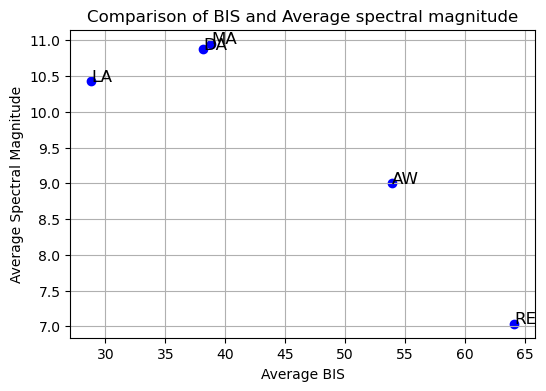

In [130]:
average_spectral_magnitude = []

for start, end, label in L08181442_label:
    state_eeg = eeg_L08181442['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    average_spectral_magnitude.append(np.mean(avg_coefficients))  # Averaging spectral magnitude over frequencies

# Plotting BIS vs Magnitude
plt.figure(figsize = (6, 4))
plt.scatter(average_bis, average_spectral_magnitude, color='blue')
for i, label in enumerate([state[2] for state in L08181442_label]):
    plt.text(average_bis[i], average_spectral_magnitude[i], label, fontsize=12)

plt.xlabel('Average BIS')
plt.ylabel('Average Spectral Magnitude')
plt.title('Comparison of BIS and Average spectral magnitude')
plt.grid(True)
plt.show()

In [54]:
eeg_segments = []
labels = []

for start, end, label in L08181442_label:
    eeg_segment = eeg_L08181442['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L08181442_eeg_label.csv', index=False)

In [109]:
# Extract BIS with label
L08181442_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L08181442_label:
    bis_values = bis_L08181442[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L08181442_bis_label = pd.concat([L08181442_bis_label, bis_segment_df], ignore_index=True)

L08181442_bis_label.to_csv('bis_label/L08181442_label.csv', index=False)

### L08190811

In [34]:
#EEG
L08190811 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L08190811.mat')

eeg_L08190811 = L08190811['xh']
eeg_L08190811 = pd.DataFrame(eeg_L08190811)
eeg_L08190811 = eeg_L08190811.stack().reset_index(drop = True).to_frame()
eeg_L08190811.columns = ['eeg']

#BIS
bis_L08190811 = np.repeat(bis['BIS_L08190811'].dropna().values, 128)

#PDOA
pdoa_L08190811 = pd.read_csv('pdoa/08190811.csv', header = None)
pdoa_L08190811.columns = ['X', 'pdoa']

eeg_length = len(eeg_L08190811)
pdoa_resampled = scipy.signal.resample(pdoa_L08190811['pdoa'], eeg_length)
pdoa_L08190811 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

In [35]:
#Normalise
pdoa_L08190811['pdoa'] = (pdoa_L08190811['pdoa'] - pdoa_L08190811['pdoa'].mean()) / pdoa_L08190811['pdoa'].std()

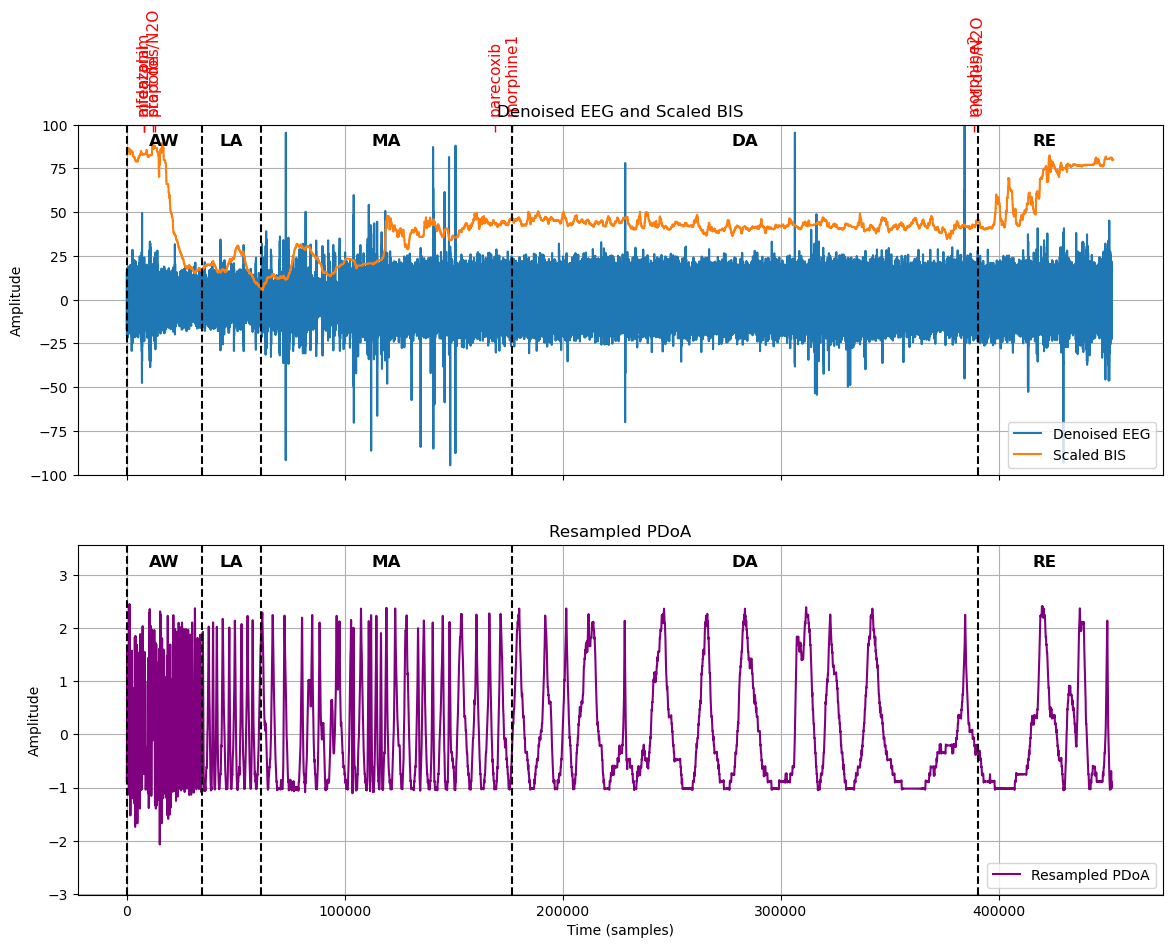

In [36]:
event_times = {
    "midazolam": "08:12:00",
    "alfentanil": "08:12:00",
    "propofol": "08:12:35",
    "start des/N2O": "08:12:40",
    "parecoxib": "08:33:00",
    "morphine1": "08:34:00",
    "morphine2": "09:01:35",
    "end des/N2O": "09:01:50"
}

time_seconds = {}
start_time = "08:11:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L08190811, label='Denoised EEG')
axs[0].plot(bis_L08190811, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L08190811, label='Resampled PDoA', color='purple')
axs[1].set_ylim(np.min(pdoa_L05211742) - 1, np.max(pdoa_L05211742) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L08190811_label = [
    (0, 34560, 'AW'),
    (34560, 61440, 'LA'),
    (61440, 176640, 'MA'),
    (176640, 390400, 'DA'),
    (390400, eeg_length, 'RE')
]

for start, end, label in L08190811_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [76]:
# Calculate entropy for each anesthesia state
for start, end, label in L08190811_label:
    state_eeg = eeg_L08190811['eeg'][start:end]
    entropy = shannon_entropy(state_eeg)
    print(f'{label} Entropy: {entropy}')

AW Entropy: 1.5576637562354456
LA Entropy: 1.7915176498803358
MA Entropy: 1.099737340228419
DA Entropy: 1.1560973612883632
RE Entropy: 1.387843909869526


/Users/pdmnhtrang/anaconda3/lib/python3.11/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


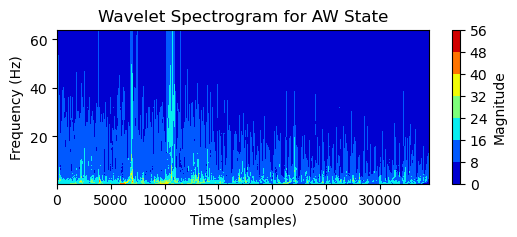

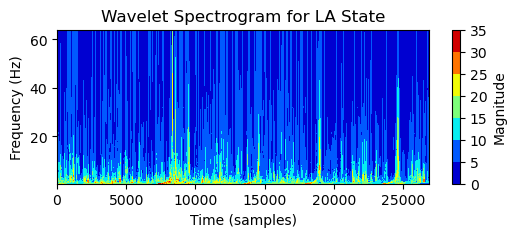

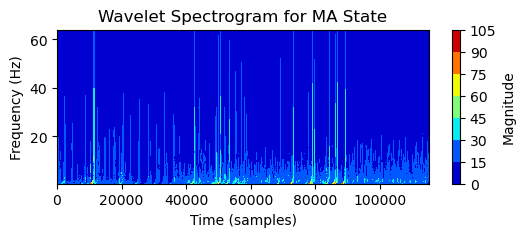

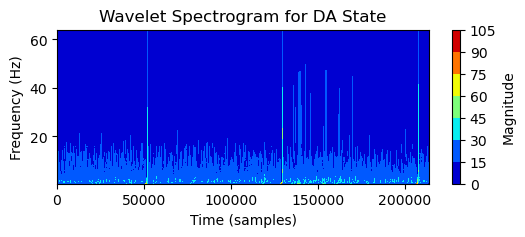

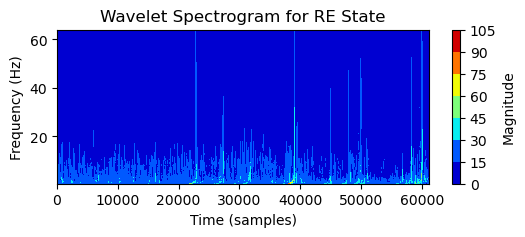

In [136]:
# Plot the wavelet spectrogram for each state
for start, end, label in L08190811_label:
    state_eeg = eeg_L08190811['eeg'][start:end].values
    plot_wavelet_spectrogram(state_eeg, scales, label=label)

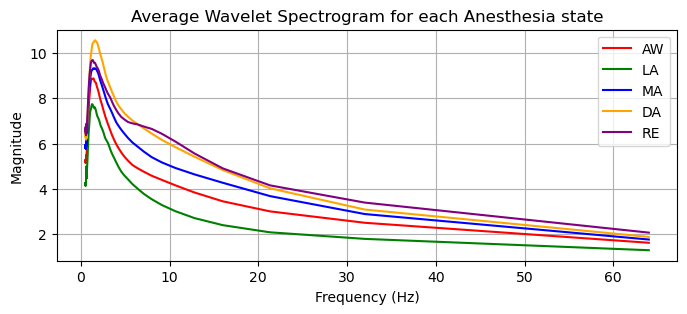

In [137]:
plt.figure(figsize=(8, 3))
colors = ['red', 'green', 'blue', 'orange', 'purple']

#Plot Average wavelet spectrogram for each state
for idx, (start, end, label) in enumerate(L08190811_label):
    state_eeg = eeg_L08190811['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    plt.plot(frequencies, avg_coefficients, color=colors[idx], label=label)

plt.title('Average Wavelet Spectrogram for each Anesthesia state')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [138]:
bis_time = np.linspace(0, len(eeg_L08190811), num=len(bis_L08190811), endpoint=False)
interp_func = interp1d(bis_time, bis_L08190811, kind='linear', fill_value='extrapolate')
bis_resampled = interp_func(np.arange(len(eeg_L08190811)))

average_bis = []

for start, end, label in L08190811_label:
    avg_bis = np.mean(bis_resampled[start:end])
    average_bis.append(avg_bis)
    print(f'{label} Average BIS: {avg_bis}')

AW Average BIS: 57.25199690264863
LA Average BIS: 18.91949432256949
MA Average BIS: 30.551061349890734
DA Average BIS: 42.77866661377355
RE Average BIS: 64.44209227559297


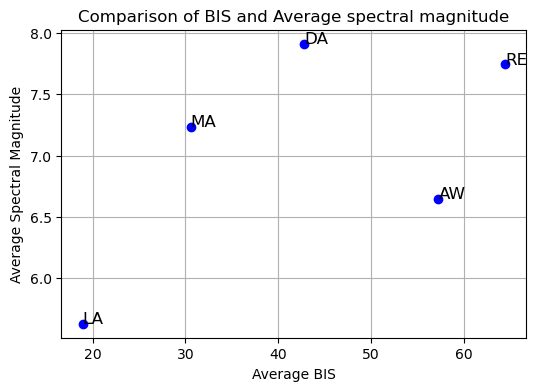

In [139]:
average_spectral_magnitude = []

for start, end, label in L08190811_label:
    state_eeg = eeg_L08190811['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    average_spectral_magnitude.append(np.mean(avg_coefficients))  # Averaging spectral magnitude over frequencies

# Plotting BIS vs Magnitude
plt.figure(figsize = (6, 4))
plt.scatter(average_bis, average_spectral_magnitude, color='blue')
for i, label in enumerate([state[2] for state in L08190811_label]):
    plt.text(average_bis[i], average_spectral_magnitude[i], label, fontsize=12)

plt.xlabel('Average BIS')
plt.ylabel('Average Spectral Magnitude')
plt.title('Comparison of BIS and Average spectral magnitude')
plt.grid(True)
plt.show()

In [58]:
eeg_segments = []
labels = []

for start, end, label in L08190811_label:
    eeg_segment = eeg_L08190811['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L08190811_eeg_label.csv', index=False)

In [110]:
# Extract BIS with label
L08190811_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L08190811_label:
    bis_values = bis_L08190811[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L08190811_bis_label = pd.concat([L08190811_bis_label, bis_segment_df], ignore_index=True)

L08190811_bis_label.to_csv('bis_label/L08190811_label.csv', index=False)

### L08190921

In [37]:
#EEG
L08190921 = scipy.io.loadmat('denoise EEG/denoiseEEGsignal_L08190921.mat')

eeg_L08190921 = L08190921['xh']
eeg_L08190921 = pd.DataFrame(eeg_L08190921)
eeg_L08190921 = eeg_L08190921.stack().reset_index(drop = True).to_frame()
eeg_L08190921.columns = ['eeg']

#BIS
bis_L08190921 = np.repeat(bis['BIS_L08190921'].dropna().values, 128)

#PDOA
pdoa_L08190921 = pd.read_csv('pdoa/08190921.csv', header = None)
pdoa_L08190921.columns = ['X', 'pdoa']

eeg_length = len(eeg_L08190921)
pdoa_resampled = scipy.signal.resample(pdoa_L08190921['pdoa'], eeg_length)
pdoa_L08190921 = pd.DataFrame(pdoa_resampled, columns=['pdoa'])

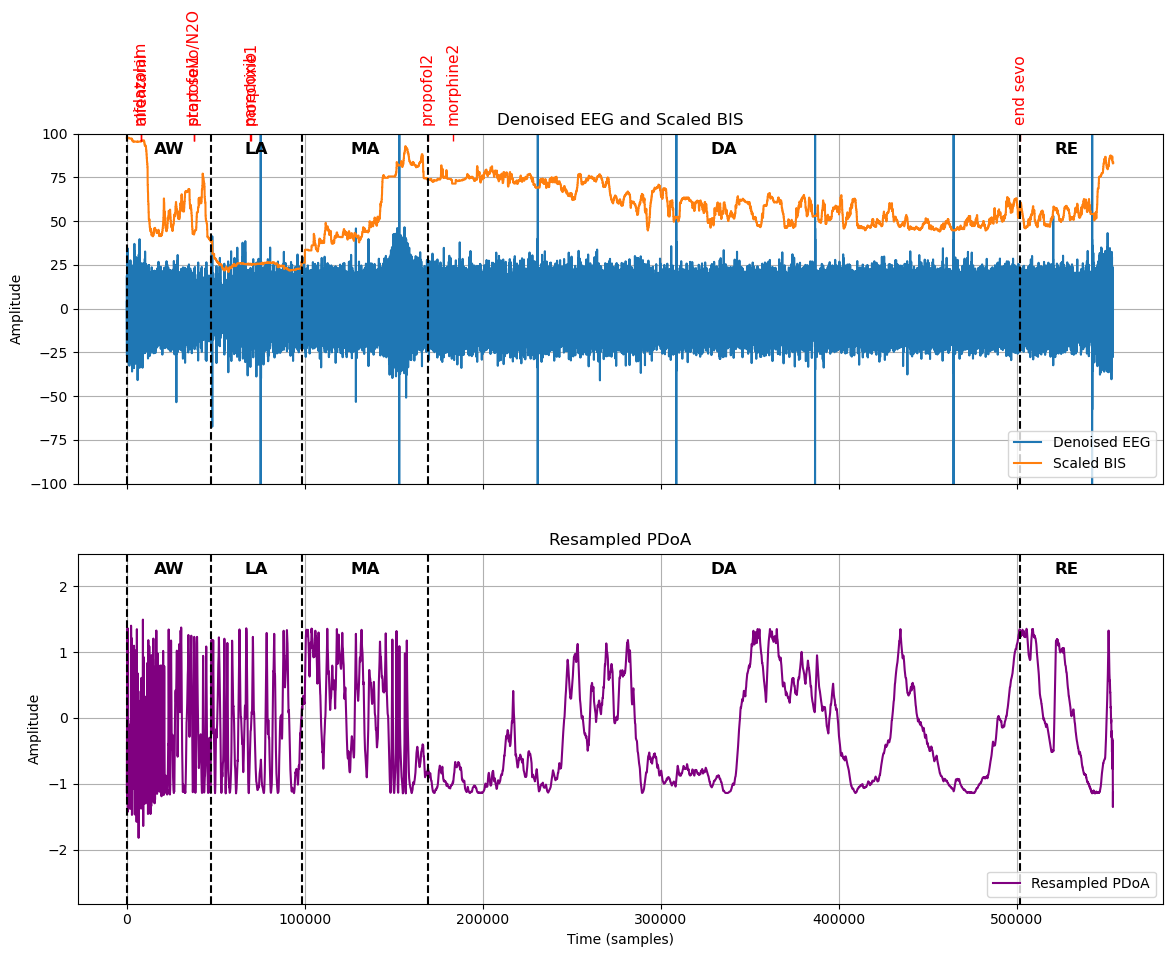

In [38]:
event_times = {
    "midazolam": "09:22:00",
    "alfentanil": "09:22:03",
    "propofol1": "09:25:53",
    "start sevo/N2O": "09:25:55",
    "parecoxib": "09:30:00",
    "morphine1": "09:30:05",
    "propofol2": "09:43:00",
    "morphine2": "09:44:50",
    "end sevo": "10:26:20"
}

time_seconds = {}
start_time = "09:21:00" 
start_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(start_time.split(":"))))
for event, time in event_times.items():
    event_seconds = sum(int(x) * 60 ** i for i, x in enumerate(reversed(time.split(":"))))
    time_seconds[event] = (event_seconds - start_seconds) * 128

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot the EEG and BIS signals in the first subplot
axs[0].plot(eeg_L08190921, label='Denoised EEG')
axs[0].plot(bis_L08190921, label='Scaled BIS')
axs[0].set_ylim(-100, 100)
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Denoised EEG and Scaled BIS')
axs[0].legend(loc='lower right')
axs[0].grid(True)

for event, seconds in time_seconds.items():
    axs[0].plot(seconds, axs[0].get_ylim()[1], marker='|', color='red', markersize=10, linestyle='None')
    axs[0].text(seconds, axs[0].get_ylim()[1] * 1.05, event,
             rotation=90, va='bottom', ha='center', color='red', fontsize=11)

axs[1].plot(pdoa_L08190921, label='Resampled PDoA', color='purple')
axs[1].set_ylim(min(pdoa_resampled) - 1, max(pdoa_resampled) + 1)
axs[1].set_xlabel('Time (samples)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Resampled PDoA')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Resampled PDoA')
plt.legend(loc='lower right')
plt.grid(True)

L08190921_label = [
    (0, 47000, 'AW'),
    (47000, 98560, 'LA'),
    (98560, 168960, 'MA'),
    (168960, 501760, 'DA'),
    (501760, eeg_length, 'RE')
]

for start, end, label in L08190921_label:
    axs[0].axvline(x=start, color='black', linestyle='--')
    axs[0].text((start + end) / 2, axs[0].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    axs[1].axvline(x=start, color='black', linestyle='--')
    axs[1].text((start + end) / 2, axs[1].get_ylim()[1] * 0.95, label,
                rotation=0, va='top', ha='center', color='black', fontsize=12, fontweight='bold')
    
plt.show()

In [79]:
# Calculate entropy for each anesthesia state
for start, end, label in L08190921_label:
    state_eeg = eeg_L08190921['eeg'][start:end]
    entropy = shannon_entropy(state_eeg)
    print(f'{label} Entropy: {entropy}')

AW Entropy: 1.8728728171213063
LA Entropy: 1.0366612391913574
MA Entropy: 1.0672548594003781
DA Entropy: 0.9919708939753971
RE Entropy: 1.1112341794162206


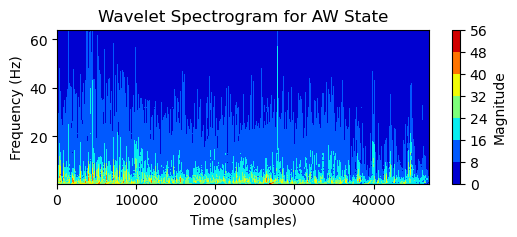

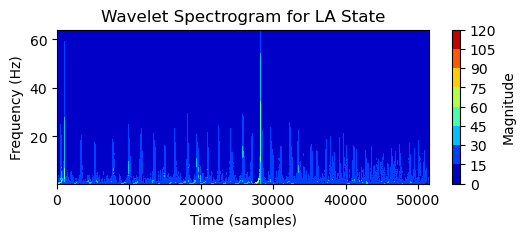

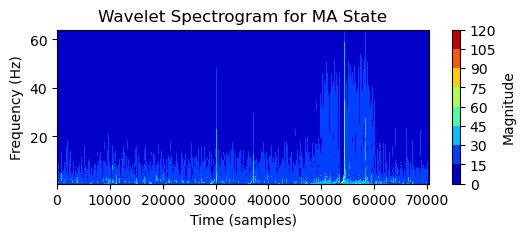

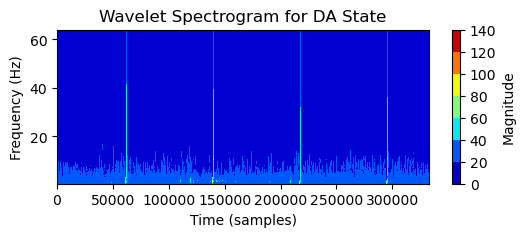

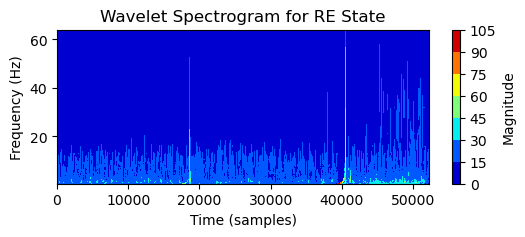

In [149]:
# Plot the wavelet spectrogram for each state
for start, end, label in L08190921_label:
    state_eeg = eeg_L08190921['eeg'][start:end].values
    plot_wavelet_spectrogram(state_eeg, scales, label=label)

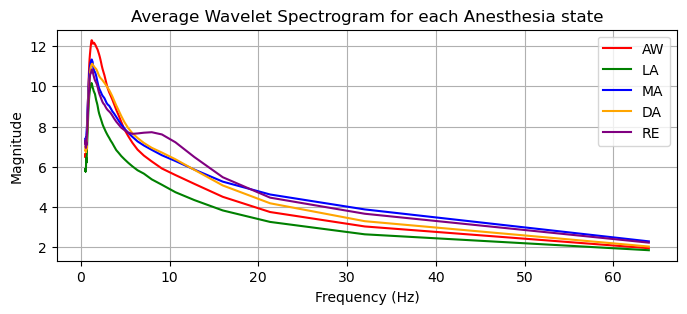

In [150]:
plt.figure(figsize=(8, 3))
colors = ['red', 'green', 'blue', 'orange', 'purple']

#Plot Average wavelet spectrogram for each state
for idx, (start, end, label) in enumerate(L08190921_label):
    state_eeg = eeg_L08190921['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    plt.plot(frequencies, avg_coefficients, color=colors[idx], label=label)

plt.title('Average Wavelet Spectrogram for each Anesthesia state')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [151]:
bis_time = np.linspace(0, len(eeg_L08190921), num=len(bis_L08190921), endpoint=False)
interp_func = interp1d(bis_time, bis_L08190921, kind='linear', fill_value='extrapolate')
bis_resampled = interp_func(np.arange(len(eeg_L08190921)))

average_bis = []

for start, end, label in L08190921_label:
    avg_bis = np.mean(bis_resampled[start:end])
    average_bis.append(avg_bis)
    print(f'{label} Average BIS: {avg_bis}')

AW Average BIS: 63.268174845763944
LA Average BIS: 25.144117058783443
MA Average BIS: 55.84404400583735
DA Average BIS: 60.266746853168485
RE Average BIS: 58.12698636871674


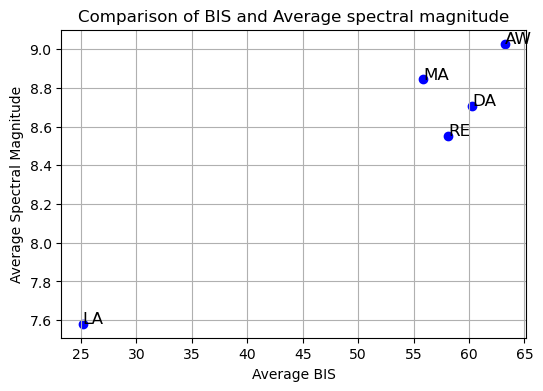

In [152]:
average_spectral_magnitude = []

for start, end, label in L08190921_label:
    state_eeg = eeg_L08190921['eeg'][start:end].values
    frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
    average_spectral_magnitude.append(np.mean(avg_coefficients))  # Averaging spectral magnitude over frequencies

# Plotting BIS vs Magnitude
plt.figure(figsize = (6, 4))
plt.scatter(average_bis, average_spectral_magnitude, color='blue')
for i, label in enumerate([state[2] for state in L08190921_label]):
    plt.text(average_bis[i], average_spectral_magnitude[i], label, fontsize=12)

plt.xlabel('Average BIS')
plt.ylabel('Average Spectral Magnitude')
plt.title('Comparison of BIS and Average spectral magnitude')
plt.grid(True)
plt.show()

In [61]:
eeg_segments = []
labels = []

for start, end, label in L08190921_label:
    eeg_segment = eeg_L08190921['eeg'][start:end].values
    eeg_segments.extend(eeg_segment)
    labels.extend([label] * len(eeg_segment))

eeg_with_labels = pd.DataFrame({
    'EEG': eeg_segments,
    'Label': labels})

eeg_with_labels.to_csv('eeg_label/L08190921_eeg_label.csv', index=False)

In [111]:
# Extract BIS with label
L08190921_bis_label = pd.DataFrame(columns=['BIS', 'Label'])

for start, end, label in L08190921_label:
    bis_values = bis_L08190921[start:end]
    labels = [label] * len(bis_values)
    bis_segment_df = pd.DataFrame({'BIS': bis_values, 'Label': labels})
    L08190921_bis_label = pd.concat([L08190921_bis_label, bis_segment_df], ignore_index=True)

L08190921_bis_label.to_csv('bis_label/L08190921_label.csv', index=False)

## Visualisation

In [47]:
patient_list = [
    "L05200708",
    "L05211742",
    "L05250816",
    "L05250921",
    "L05271431",
    "L05281010",
    "L06101015",
    "L06181302",
    "L06181332",
    "L06221009",
    "L06221141",
    "L06221219",
    "L08181442",
    "L08190811",
    "L08190921"]

In [55]:
entropy_data = []

# Loop through each patient in the list
for patient in patient_list:
    # Access the EEG data for the patient dynamically
    eeg_data = globals()[f'eeg_{patient}']
    
    # Access the labels for the patient dynamically
    patient_label = globals()[f'{patient}_label']
    
    # Calculate entropy for each anesthesia state
    for start, end, label in patient_label:
        state_eeg = eeg_data['eeg'][start:end]
        entropy_value = shannon_entropy(state_eeg)  # Assuming shannon_entropy is already defined
        
        # Append the data to the list
        entropy_data.append({
            "Patient": patient,
            "State": label,
            "Entropy": entropy_value
        })

entropy_df = pd.DataFrame(entropy_data)

In [129]:
bis_df = pd.DataFrame(columns=["Patient", "State", "BIS"])

# Function to compute average BIS for each state in a given patient's data
def compute_avg_bis(patient, bis_data):
    global bis_df
    
    # Group by 'Label' and compute the mean of 'BIS' for each state
    avg_bis_by_state = bis_data.groupby('Label')['BIS'].mean().reset_index()
    
    # Add the patient information to the DataFrame
    avg_bis_by_state['Patient'] = patient
    
    # Append the data to the main DataFrame
    bis_df = pd.concat([bis_df, avg_bis_by_state])

# Iterate over each patient to calculate their average BIS
for patient in patient_list:
    bis_data = globals()[f'{patient}_bis_label']  # Load the BIS and label data for each patient
    
    # Compute the average BIS for each state
    compute_avg_bis(patient, bis_data)

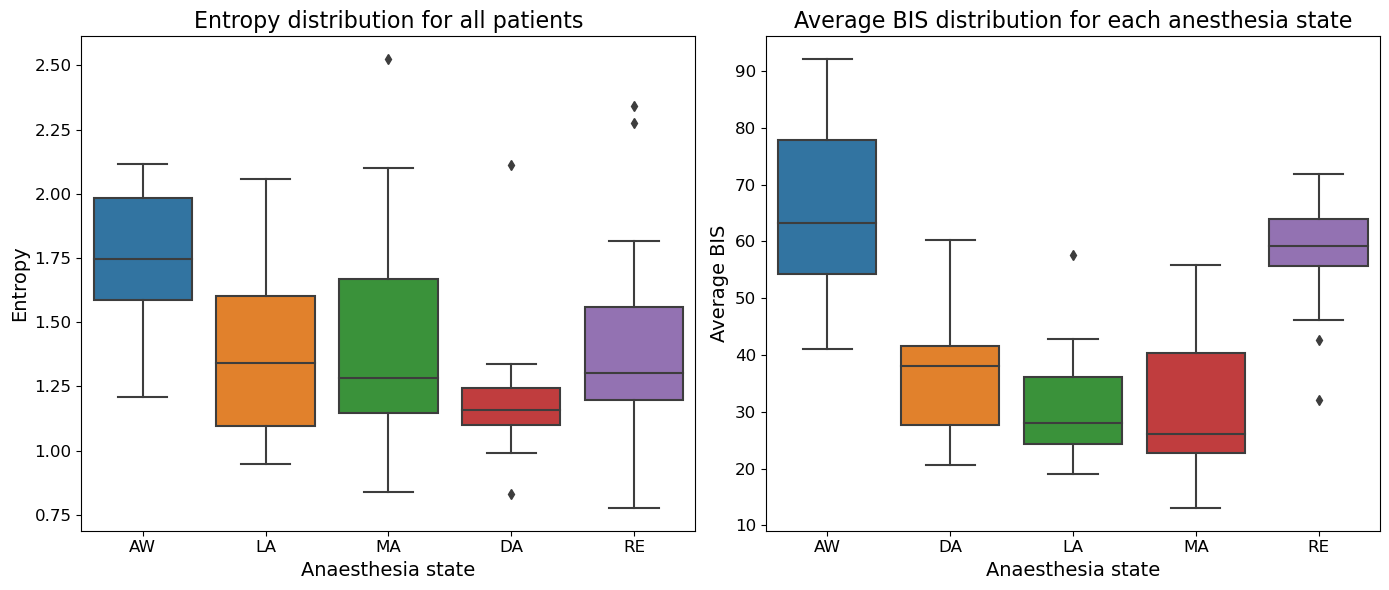

In [130]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the Entropy vs Anesthesia State for All Patients
sns.boxplot(x='State', y='Entropy', data=entropy_df, ax=axes[0])
axes[0].set_title('Entropy distribution for all patients', fontsize=16)
axes[0].set_xlabel('Anaesthesia state', fontsize=14)
axes[0].set_ylabel('Entropy', fontsize=14)

axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Plot the Average BIS Distribution for Each Anesthesia State
sns.boxplot(x='Label', y='BIS', data=bis_df, ax=axes[1])
axes[1].set_title('Average BIS distribution for each anesthesia state', fontsize=16)
axes[1].set_xlabel('Anaesthesia state', fontsize=14)
axes[1].set_ylabel('Average BIS', fontsize=14)

axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Entropy: Decreases significantly as patients move from awake (AW) to deep anesthesia (DA), then increases again during recovery (RE)
BIS: Follows a similar trend, where higher BIS values correspond to lighter anesthesia (AW, RE), and lower BIS values are observed in deeper anesthesia (DA, MA), reflecting a reduction in consciousness.

/Users/pdmnhtrang/anaconda3/lib/python3.11/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


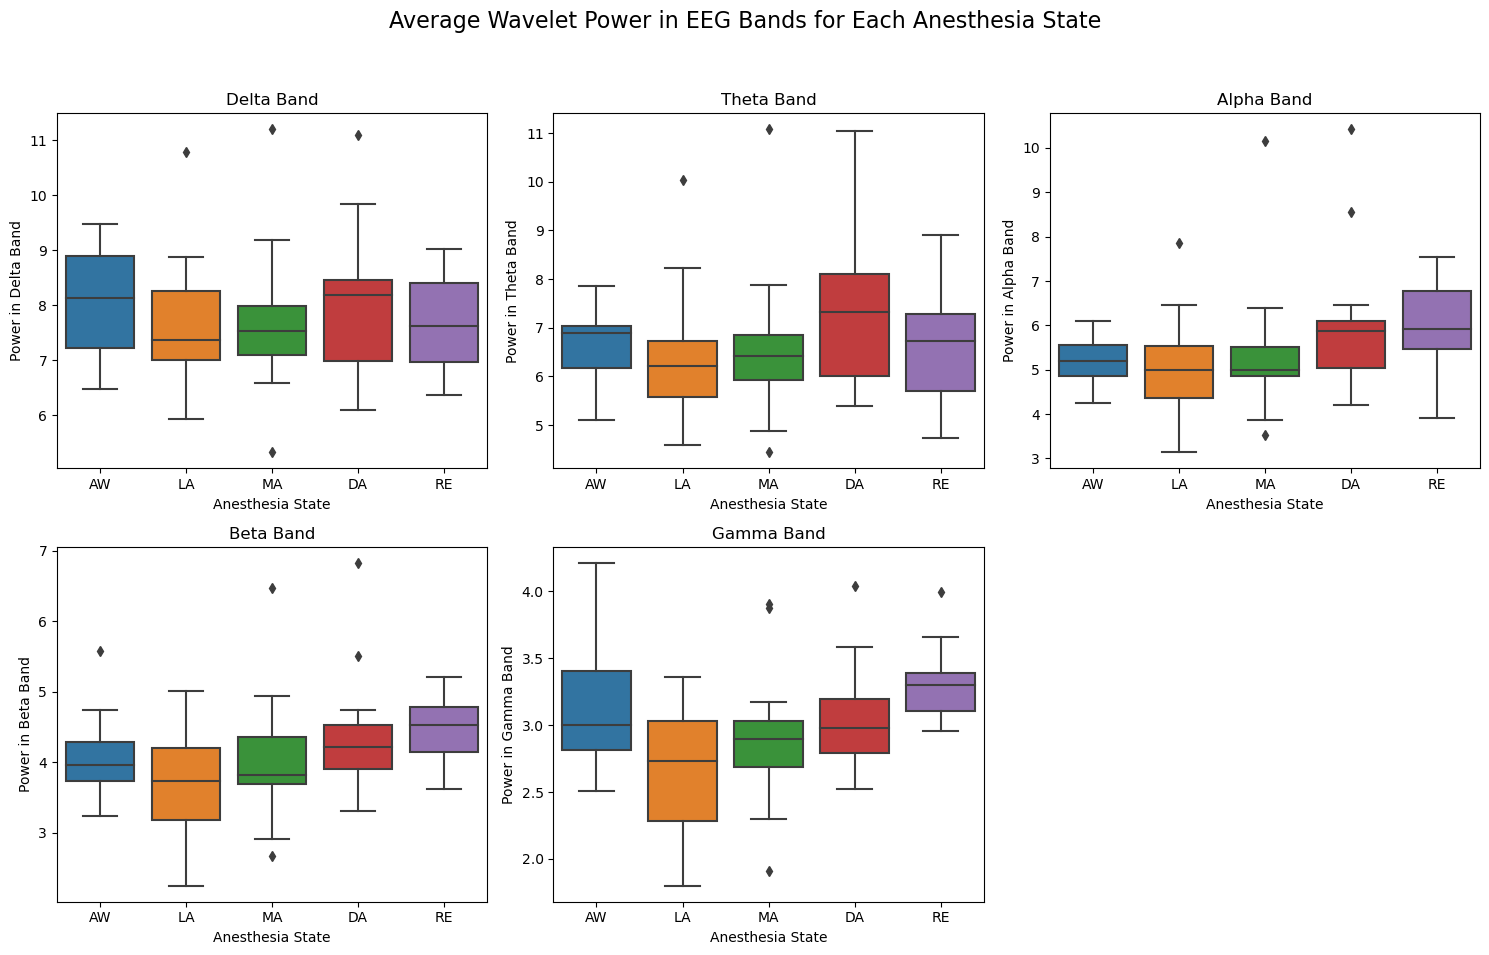

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

eeg_bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 7),
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 49)
}


def calculate_band_power(frequencies, avg_coefficients, band):
    band_min, band_max = band
    # Find indices corresponding to the band range
    band_indices = np.where((frequencies >= band_min) & (frequencies <= band_max))
    # Calculate the average power within this band
    band_power = np.mean(avg_coefficients[band_indices])
    return band_power

# Create an empty DataFrame to store results
wavelet_power_df = pd.DataFrame(columns=['Patient', 'State', 'Band', 'Power'])

# Loop through patients and states to calculate average wavelet power for each band
for patient in patient_list:
    eeg_data = globals()[f'eeg_{patient}']  # Load EEG data
    labels = globals()[f'{patient}_label']  # Load state labels
    
    for start, end, label in labels:
        state_eeg = eeg_data['eeg'][start:end].values
        frequencies, avg_coefficients = average_wavelet_spectrogram(state_eeg, scales)
        
        # Calculate the average power in each band
        for band_name, band_range in eeg_bands.items():
            band_power = calculate_band_power(frequencies, avg_coefficients, band_range)
            
            # Append to the DataFrame using pd.concat()
            new_row = pd.DataFrame({
                'Patient': [patient],
                'State': [label],
                'Band': [band_name],
                'Power': [band_power]
            })
            
            wavelet_power_df = pd.concat([wavelet_power_df, new_row], ignore_index=True)

# Plot all bands in a grid of 3 plots in the first row and 2 plots in the second row
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust figsize for smaller plots

# Flatten axes for easier access
axes = axes.flatten()

# Remove the last (6th) subplot as we only need 5 plots
fig.delaxes(axes[5])

# Plot each EEG band
for idx, (band_name, _) in enumerate(eeg_bands.items()):
    # Filter the data for the current band
    band_data = wavelet_power_df[wavelet_power_df['Band'] == band_name]
    
    # Create the box plot in the appropriate subplot
    sns.boxplot(ax=axes[idx], x='State', y='Power', data=band_data)
    
    # Customize each subplot
    axes[idx].set_title(f'{band_name} Band')
    axes[idx].set_xlabel('Anesthesia State')
    axes[idx].set_ylabel(f'Power in {band_name} Band')

# Add an overall title for the entire figure
plt.suptitle('Average Wavelet Power in EEG Bands for Each Anesthesia State', fontsize=16)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plots
plt.show()


In [67]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd

# Merge wavelet power and entropy on 'Patient' and 'State'
combined_df = pd.merge(wavelet_power_df, entropy_df, on=['Patient', 'State'])

pivot_df = combined_df.pivot_table(index=['Patient', 'State'], columns='Band', values='Power').reset_index()

# add Entropy as a separate column
pivot_df['Entropy'] = pivot_df.apply(lambda row: entropy_df[
    (entropy_df['Patient'] == row['Patient']) & (entropy_df['State'] == row['State'])
]['Entropy'].values[0], axis=1)

# Define features (X) and labels (y)
X = pivot_df[['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'Entropy']]  # Features
y = pivot_df['State']  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#train KNN
knn = KNeighborsClassifier(n_neighbors = 5, metric='euclidean')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)


print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:", accuracy_score(y_test, y_pred))


Confusion Matrix:
[[2 0 0 1 0]
 [0 0 1 0 0]
 [0 1 0 1 0]
 [0 3 0 0 0]
 [2 0 1 0 3]]

Classification Report:
              precision    recall  f1-score   support

          AW       0.50      0.67      0.57         3
          DA       0.00      0.00      0.00         1
          LA       0.00      0.00      0.00         2
          MA       0.00      0.00      0.00         3
          RE       1.00      0.50      0.67         6

    accuracy                           0.33        15
   macro avg       0.30      0.23      0.25        15
weighted avg       0.50      0.33      0.38        15


Accuracy Score: 0.3333333333333333


/Users/pdmnhtrang/anaconda3/lib/python3.11/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


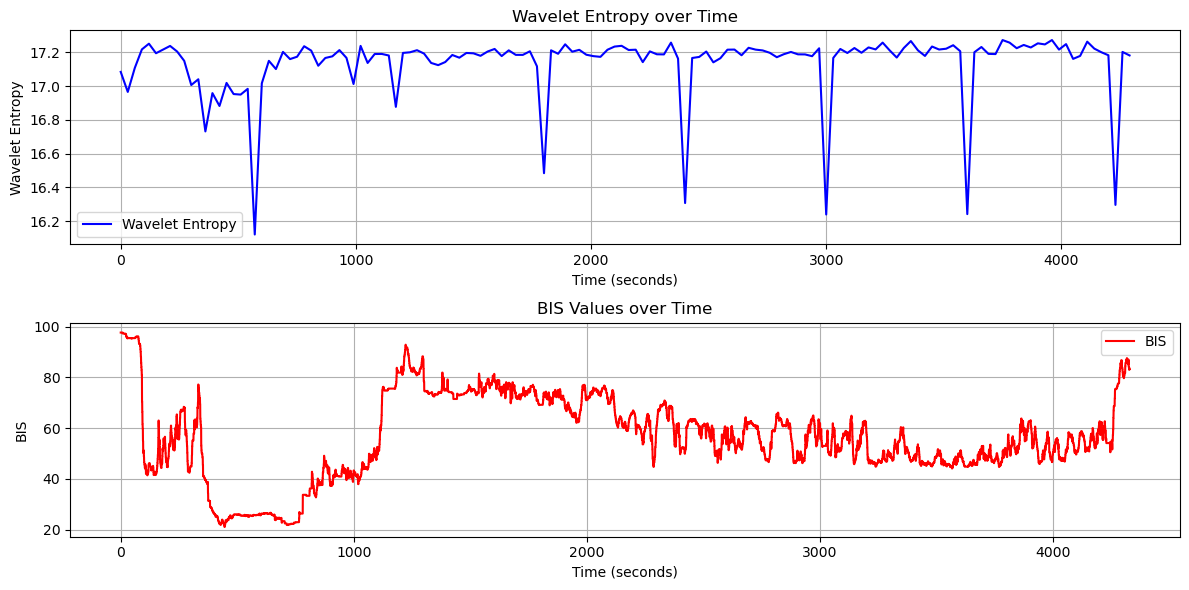

In [43]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Assuming bis_L08190921 is already loaded as a NumPy array
# eeg_L08190921 should also be a NumPy array of EEG data

eeg_data = eeg_L08190921  # Example EEG data for one patient
bis_data = bis_L08190921  # BIS data is already a NumPy array

# Function to compute wavelet entropy for a segment of EEG using continuous wavelet (cmor)
def wavelet_entropy(eeg_segment, wavelet_name='cmor'):
    # Perform continuous wavelet transform (CWT) with a continuous wavelet
    scales = np.arange(1, 128)
    coefficients, frequencies = pywt.cwt(eeg_segment, scales, wavelet_name)
    
    # Compute the power (square of coefficients)
    power = np.square(np.abs(coefficients))
    
    # Normalize the power
    total_power = np.sum(power)
    power_normalized = power / total_power
    
    # Calculate the entropy
    entropy = -np.sum(power_normalized * np.log2(power_normalized + np.finfo(float).eps))  # Avoid log(0)
    return entropy

# Segment the EEG data into 30-second windows (assuming a sampling rate of 128 Hz)
window_size = 30 * 128  # 30 seconds * 128 samples/second
num_windows = len(eeg_data) // window_size

wavelet_entropies = []
time_points = []

# Compute wavelet entropy for each window
for i in range(num_windows):
    start = i * window_size
    end = start + window_size
    eeg_segment = eeg_data[start:end]
    entropy = wavelet_entropy(eeg_segment)
    wavelet_entropies.append(entropy)
    time_points.append(i * 30)  # Every 30 seconds

# Plot the wavelet entropy and BIS values over time
plt.figure(figsize=(12, 6))

# Plot wavelet entropy
plt.subplot(2, 1, 1)
plt.plot(time_points, wavelet_entropies, label='Wavelet Entropy', color='blue')
plt.title('Wavelet Entropy over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Wavelet Entropy')
plt.grid(True)
plt.legend()

# Plot BIS values
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(bis_data)) / 128, bis_data, label='BIS', color='red')  # Adjust time scale if needed
plt.title('BIS Values over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('BIS')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [40]:
print(type(bis_L08190921))

<class 'numpy.ndarray'>
